<a href="https://colab.research.google.com/github/daniui/Machine-Learning-Project/blob/main/RISTEK%20datathon%202024/datathon_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pendahuluan**
Pada era digital saat ini, *platform fintech* semakin populer karena kenyamanan dan inovasi yang ditawarkan dalam layanan keuangan. Sayangnya, hal ini juga disertai dengan peningkatan risiko aktivitas penipuan, yang dapat merugikan baik penyedia layanan maupun pengguna. Deteksi *fraud* yang cepat dan akurat sangat penting untuk mempertahankan integritas dan kepercayaan pengguna pada platform tersebut.


Tujuan dari kompetisi ini adalah untuk menciptakan model *machine learning* yang mampu mengenali pengguna yang terlibat dalam aktivitas penipuan di *platform fintech*. Model ini diharapkan dapat mengidentifikasi perilaku mencurigakan berdasarkan data pengguna, aktivitas pinjaman, dan informasi lain yang tersedia. Selain menciptakan model klasifikasi yang efektif, juga dilakukan analisis pola pengguna yang diidentifikasi sebagai penipuan. Analisis ini penting untuk memberikan wawasan mendalam tentang cara kerja model dan memastikan bahwa deteksi fraud dilakukan secara adil dan transparan.


Melalui pendekatan ini, kami berharap dapat berkontribusi untuk meningkatkan keamanan dan kepercayaan pada *platform fintech* serta memberikan dasar yang kuat untuk pengembangan lebih lanjut dari metode deteksi fraud di masa depan.

#Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost
!pip install optuna
!pip install vecstack
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vecstack: filename=vecstack-0.4.0-py3-none-any.whl size=19863 sha256=60518e50566c1c0de924b26ade923ec189f876da02e8110367d65c62ab655e26
  Stored in directory: /root/.cache/pip/wheels/b8/d8/51/3cf39adf22c522b0a91dc2208db4e9de4d2d9d171683596220
Successfully built vecstack


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn import tree, linear_model, ensemble, naive_bayes, neighbors, svm,  cluster, decomposition
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb
from catboost import EFeaturesSelectionAlgorithm
from sklearn.ensemble import VotingClassifier, StackingClassifier

from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures, MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer
#from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold, cross_val_predict
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif, SequentialFeatureSelector, RFE, RFECV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, average_precision_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import optuna
from optuna.samplers import TPESampler
from vecstack import stacking
from imblearn.over_sampling import *
from imblearn.under_sampling import *
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import make_pipeline as make_ImbPipeline
from imblearn import ensemble as Imbensemble

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset

# Data Loading

In [ ]:
loan_activities_df = pd.read_csv("/content/drive/MyDrive/Datathon 2024_DMR/Lomba/ristek-datathon-2024/loan_activities.csv")
non_borrower_df = pd.read_csv("/content/drive/MyDrive/Datathon 2024_DMR/Lomba/ristek-datathon-2024/non_borrower_user.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Datathon 2024_DMR/Lomba/ristek-datathon-2024/test.csv")
train_df = pd.read_csv("/content/drive/MyDrive/Datathon 2024_DMR/Lomba/ristek-datathon-2024/train.csv")
train_df

user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
0             3  1.0  1.0  0.275  0.255  0.927273  0.4  0.260  0.040  0.254   
1             5  0.0  0.0  0.430  0.365  0.848837  0.4  1.253  0.210  1.235   
2             9  1.0  3.0  1.315  0.825  0.627376  0.9  2.385  0.128  2.270   
3            10  0.0  5.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
4            17  1.0  1.0  0.235  0.160  0.680851  0.1  0.120  0.002  0.104   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857894  3700529  1.0  4.0  0.190  0.160  0.842105  0.1  0.281  0.005  0.274   
857895  3700532  1.0  3.0  1.710  1.535  0.897661  2.1  3.750  0.687  3.712   
857896  3700537  1.0  0.0  2.165  2.060  0.951501  2.4  2.213  0.065  2.186   
857897  3700543  1.0  5.0  2.075  1.565  0.754217  1.9  3.292  0.342  3.188   
857898  3700548  0.0  4.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   

             pc9  pc10      pc11      pc12      pc13      pc14      pc15  \
0       0.976923   1.0  0.072727  0.023077  0.078431  0.750000  0.018182   
1       0.985634   1.0  0.151163  0.014366  0.054795  0.500000  0.011628   
2       0.951782   1.0  0.372624  0.048218  0.054545  0.777778  0.003802   
3      -1.000000   0.0 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
4       0.866667   0.0  0.319149  0.133333  0.031250 -1.000000 -1.000000   
...          ...   ...       ...       ...       ...       ...       ...   
857894  0.975089   0.0  0.157895  0.024911  0.031250  1.000000 -1.000000   
857895  0.989867   4.0  0.102339  0.010133  0.068404  0.857143  0.011696   
857896  0.987799   2.0  0.048499  0.012201  0.058252  0.458333  0.004619   
857897  0.968408   4.0  0.245783  0.031592  0.060703  0.736842  0.009639   
857898 -1.000000   0.0 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   

            pc16  label  
0       0.250000      0  
1       0.250000      0  
2       0.111111      0  
3      -1.000000      0  
4      -1.000000      0  
...          ...    ...  
857894 -1.000000      0  
857895  0.190476      0  
857896  0.083333      0  
857897  0.210526      0  
857898 -1.000000      0  

[857899 rows x 19 columns]

In [ ]:
display(train_df.info())
display(train_df.describe())
print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
display(test_df.info())
display(test_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857899 entries, 0 to 857898
Data columns (total 19 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  857899 non-null  int64  
 1   pc0      857899 non-null  float64
 2   pc1      857899 non-null  float64
 3   pc2      857899 non-null  float64
 4   pc3      857899 non-null  float64
 5   pc4      857899 non-null  float64
 6   pc5      857899 non-null  float64
 7   pc6      857899 non-null  float64
 8   pc7      857899 non-null  float64
 9   pc8      857899 non-null  float64
 10  pc9      857899 non-null  float64
 11  pc10     857899 non-null  float64
 12  pc11     857899 non-null  float64
 13  pc12     857899 non-null  float64
 14  pc13     857899 non-null  float64
 15  pc14     857899 non-null  float64
 16  pc15     857899 non-null  float64
 17  pc16     857899 non-null  float64
 18  label    857899 non-null  int64  
dtypes: float64(17), int64(2)
memory usage: 124.4 MB


None

user_id            pc0            pc1            pc2  \
count  8.578990e+05  857899.000000  857899.000000  857899.000000   
mean   1.851235e+06       0.746870       3.709053       0.545364   
std    1.069052e+06       0.439532       1.934880       1.941448   
min    3.000000e+00      -1.000000      -1.000000      -1.000000   
25%    9.251405e+05       0.000000       2.000000      -1.000000   
50%    1.851614e+06       1.000000       4.000000       0.365000   
75%    2.778174e+06       1.000000       5.000000       1.150000   
max    3.700548e+06       1.000000       8.000000     111.815000   

                 pc3            pc4            pc5            pc6  \
count  857899.000000  857899.000000  857899.000000  857899.000000   
mean        0.391718       0.175067       0.315356       0.961431   
std         1.766663       0.880198       1.790893       2.766861   
min        -1.000000      -1.000000      -1.000000      -1.000000   
25%        -1.000000      -1.000000      -1.000000      -1.000000   
50%         0.295000       0.738007       0.300000       0.312000   
75%         0.915000       0.884120       0.900000       1.501000   
max       111.475000       1.000000     456.300000      64.119000   

                 pc7           pc8            pc9           pc10  \
count  857899.000000  857899.00000  857899.000000  857899.000000   
mean       -0.245161       0.91576       0.251290       1.336002   
std         0.696857       2.71027       0.932444       3.565165   
min        -1.000000      -1.00000      -1.000000       0.000000   
25%        -1.000000      -1.00000      -1.000000       0.000000   
50%         0.011000       0.28700       0.922936       0.000000   
75%         0.114000       1.43400       0.977522       2.000000   
max        12.338000      63.41600       1.000000    1313.000000   

                pc11           pc12           pc13           pc14  \
count  857899.000000  857899.000000  857899.000000  857899.000000   
mean       -0.282764      -0.358987      -0.351351       0.030651   
std         0.589381       0.522695       0.518399       0.875284   
min        -1.000000      -1.000000      -1.000000      -1.000000   
25%        -1.000000      -1.000000      -1.000000      -1.000000   
50%         0.068966       0.011834       0.029297       0.500000   
75%         0.187500       0.044816       0.057143       0.800000   
max         1.000000       1.000000       2.000000       3.000000   

                pc15           pc16          label  
count  857899.000000  857899.000000  857899.000000  
mean       -0.555226      -0.440967       0.012655  
std         0.503602       0.644649       0.111782  
min        -1.000000      -1.000000       0.000000  
25%        -1.000000      -1.000000       0.000000  
50%        -1.000000      -1.000000       0.000000  
75%         0.008230       0.200000       0.000000  
max         1.000000       1.000000       1.000000

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367702 entries, 0 to 367701
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  367702 non-null  int64  
 1   pc0      367702 non-null  float64
 2   pc1      367702 non-null  float64
 3   pc2      367702 non-null  float64
 4   pc3      367702 non-null  float64
 5   pc4      367702 non-null  float64
 6   pc5      367702 non-null  float64
 7   pc6      367702 non-null  float64
 8   pc7      367702 non-null  float64
 9   pc8      367702 non-null  float64
 10  pc9      367702 non-null  float64
 11  pc10     367702 non-null  float64
 12  pc11     367702 non-null  float64
 13  pc12     367702 non-null  float64
 14  pc13     367702 non-null  float64
 15  pc14     367702 non-null  float64
 16  pc15     367

None

user_id            pc0            pc1            pc2  \
count  3.677020e+05  367702.000000  367702.000000  367702.000000   
mean   1.846733e+06       0.746082       3.707519       0.548174   
std    1.068780e+06       0.439969       1.935365       1.948030   
min    4.000000e+00      -1.000000      -1.000000      -1.000000   
25%    9.194445e+05       0.000000       2.000000      -1.000000   
50%    1.844812e+06       1.000000       4.000000       0.360000   
75%    2.773638e+06       1.000000       5.000000       1.150000   
max    3.700544e+06       1.000000       8.000000      90.390000   

                 pc3            pc4            pc5            pc6  \
count  367702.000000  367702.000000  367702.000000  367702.000000   
mean        0.393795       0.172392       0.317049       0.966813   
std         1.772834       0.880674       1.738704       2.791356   
min        -1.000000      -1.000000      -1.000000      -1.000000   
25%        -1.000000      -1.000000      -1.000000      -1.000000   
50%         0.290000       0.736264       0.300000       0.309000   
75%         0.920000       0.883721       0.900000       1.505000   
max        90.160000       1.000000     120.200000      68.646000   

                 pc7            pc8            pc9           pc10  \
count  367702.000000  367702.000000  367702.000000  367702.000000   
mean       -0.246681       0.920817       0.248578       1.346014   
std         0.699443       2.734626       0.933026       3.514389   
min        -1.000000      -1.000000      -1.000000       0.000000   
25%        -1.000000      -1.000000      -1.000000       0.000000   
50%         0.011000       0.284000       0.922222       0.000000   
75%         0.114000       1.437000       0.977305       2.000000   
max        12.679000      68.027000       1.000000     534.000000   

                pc11           pc12           pc13           pc14  \
count  367702.000000  367702.000000  367702.000000  367702.000000   
mean       -0.283819      -0.360005      -0.353226       0.028216   
std         0.590000       0.523162       0.518760       0.875934   
min        -1.000000      -1.000000      -1.000000      -1.000000   
25%        -1.000000      -1.000000      -1.000000      -1.000000   
50%         0.068582       0.011779       0.029091       0.500000   
75%         0.187500       0.044960       0.057143       0.800000   
max         1.000000       1.000000       1.000000       2.500000   

                pc15           pc16  
count  367702.000000  367702.000000  
mean       -0.554844      -0.440620  
std         0.503653       0.644444  
min        -1.000000      -1.000000  
25%        -1.000000      -1.000000  
50%        -1.000000      -1.000000  
75%         0.008230       0.200000  
max         1.000000       1.000000

In [ ]:
##Borrower df
display(non_borrower_df)
print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
display(non_borrower_df.info())
display(non_borrower_df.describe())

user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
0              0  1.0  5.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
1              1  0.0  8.0  0.630  0.565  0.896825  0.6  2.298  0.210  2.284   
2              2 -1.0 -1.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
3              6  0.0  1.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
4              7  1.0  6.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
...          ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
2474944  3700542  1.0  7.0  0.540  0.485  0.898148  0.9  1.186  0.117  1.141   
2474945  3700545  1.0  7.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
2474946  3700546  1.0  1.0  0.125  0.125  1.000000 -1.0  0.120 -1.000  0.120   
2474947  3700547  1.0  0.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
2474948  3700549  1.0  1.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   

              pc9  pc10      pc11      pc12      pc13      pc14      pc15  \
0       -1.000000   0.0 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
1        0.993908   1.0  0.103175  0.006092  0.053097  1.000000  0.007937   
2       -1.000000   0.0 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
3       -1.000000   0.0 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
4       -1.000000   0.0 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
...           ...   ...       ...       ...       ...       ...       ...   
2474944  0.962057   2.0  0.101852  0.037943  0.092784  0.777778  0.018519   
2474945 -1.000000   0.0 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
2474946  1.000000   0.0 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
2474947 -1.000000   0.0 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   
2474948 -1.000000   0.0 -1.000000 -1.000000 -1.000000 -1.000000 -1.000000   

             pc16  
0       -1.000000  
1        0.166667  
2       -1.000000  
3       -1.000000  
4       -1.000000  
...           ...  
2474944  0.222222  
2474945 -1.000000  
2474946 -1.000000  
2474947 -1.000000  
2474948 -1.000000  

[2474949 rows x 18 columns]

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2474949 entries, 0 to 2474948
Data columns (total 18 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  int64  
 1   pc0      float64
 2   pc1      float64
 3   pc2      float64
 4   pc3      float64
 5   pc4      float64
 6   pc5      float64
 7   pc6      float64
 8   pc7      float64
 9   pc8      float64
 10  pc9      float64
 11  pc10     float64
 12  pc11     float64
 13  pc12     float64
 14  pc13     float64
 15  pc14     float64
 16  pc15     float64
 17  pc16     float64
dtypes: float64(17), int64(1)
memory usage: 339.9 MB


None

user_id           pc0           pc1           pc2           pc3  \
count  2.474949e+06  2.474949e+06  2.474949e+06  2.474949e+06  2.474949e+06   
mean   1.850468e+06  3.893608e-01  2.764487e+00 -4.021745e-01 -4.317168e-01   
std    1.067903e+06  8.221564e-01  2.868635e+00  9.459115e-01  8.954859e-01   
min    0.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
25%    9.259420e+05  0.000000e+00  0.000000e+00 -1.000000e+00 -1.000000e+00   
50%    1.850605e+06  1.000000e+00  3.000000e+00 -1.000000e+00 -1.000000e+00   
75%    2.774748e+06  1.000000e+00  5.000000e+00  2.500000e-01  2.150000e-01   
max    3.700549e+06  1.000000e+00  8.000000e+00  1.535100e+02  1.533750e+02   

                pc4           pc5           pc6           pc7           pc8  \
count  2.474949e+06  2.474949e+06  2.474949e+06  2.474949e+06  2.474949e+06   
mean  -3.160118e-01 -4.597640e-01 -3.457280e-01 -6.439547e-01 -3.544666e-01   
std    9.029973e-01  9.386454e-01  1.045472e+00  5.218496e-01  1.030386e+00   
min   -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
25%   -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
50%   -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
75%    8.414634e-01  2.000000e-01  2.340000e-01  7.000000e-03  2.200000e-01   
max    1.000000e+00  2.312000e+02  3.430200e+01  7.132000e+00  3.406400e+01   

                pc9          pc10          pc11          pc12          pc13  \
count  2.474949e+06  2.474949e+06  2.474949e+06  2.474949e+06  2.474949e+06   
mean  -2.849522e-01  4.388139e-01 -6.224855e-01 -6.535451e-01 -6.516167e-01   
std    9.420095e-01  1.567723e+00  5.433285e-01  4.967553e-01  5.024166e-01   
min   -1.000000e+00  0.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
25%   -1.000000e+00  0.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
50%   -1.000000e+00  0.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
75%    9.569075e-01  0.000000e+00  5.921053e-02  1.145663e-02  3.571429e-02   
max    1.000000e+00  4.560000e+02  1.000000e+00  1.000000e+00  1.000000e+00   

               pc14          pc15          pc16  
count  2.474949e+06  2.474949e+06  2.474949e+06  
mean  -4.517727e-01 -7.981800e-01 -7.348803e-01  
std    8.344893e-01  4.069851e-01  5.441035e-01  
min   -1.000000e+00 -1.000000e+00 -1.000000e+00  
25%   -1.000000e+00 -1.000000e+00 -1.000000e+00  
50%   -1.000000e+00 -1.000000e+00 -1.000000e+00  
75%    5.714286e-01 -1.000000e+00 -1.000000e+00  
max    3.000000e+00  1.000000e+00  1.000000e+00

In [ ]:
##loan df
display(loan_activities_df)
print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
display(loan_activities_df.info())
display(loan_activities_df.describe())

user_id  reference_contact  loan_type   ts
0        2223129             903716          1  671
1        1380939             484583          1   89
2        2724411            1185034          1  230
3        2401751            1369254          1  120
4        1982168              21797          1   57
...          ...                ...        ...  ...
4300994   468400            2004356         11  493
4300995  2844279            1657495         11  609
4300996  1071963            2316823         11    1
4300997  2803447            3513529         11  367
4300998  3342102             522089         11  427

[4300999 rows x 4 columns]

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4300999 entries, 0 to 4300998
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   user_id            int64
 1   reference_contact  int64
 2   loan_type          int64
 3   ts                 int64
dtypes: int64(4)
memory usage: 131.3 MB


None

user_id  reference_contact     loan_type            ts
count  4.300999e+06       4.300999e+06  4.300999e+06  4.300999e+06
mean   1.850565e+06       1.849301e+06  5.104953e+00  4.093275e+02
std    1.068463e+06       1.068566e+06  2.205495e+00  2.222010e+02
min    1.000000e+00       0.000000e+00  1.000000e+00  1.000000e+00
25%    9.249810e+05       9.229035e+05  4.000000e+00  2.260000e+02
50%    1.849778e+06       1.849514e+06  5.000000e+00  4.120000e+02
75%    2.776584e+06       2.775052e+06  6.000000e+00  5.820000e+02
max    3.700548e+06       3.700549e+06  1.100000e+01  8.210000e+02

#Data Preprocessing

In [ ]:
# Aggregate features for each user
agg_features = loan_activities_df.groupby('user_id').agg({
    'loan_type': ['count', 'sum', 'mean', 'min', 'max'],
    'ts':['count', 'sum', 'mean', 'min', 'max'],
    'reference_contact': ['count', 'sum', 'mean', 'min', 'max']
}).reset_index()

agg_features.columns = ['_'.join(col).strip() if col[1] else col[0] for col in agg_features.columns.values]
agg_features
#ini yang dapet 0.0444 di leaderboard

user_id  loan_type_count  loan_type_sum  loan_type_mean  \
0              1                1              2        2.000000   
1              5                2             15        7.500000   
2              7                1             11       11.000000   
3              9                3             13        4.333333   
4             10                2              8        4.000000   
...          ...              ...            ...             ...   
2190657  3700543                1              6        6.000000   
2190658  3700544                3             12        4.000000   
2190659  3700546                1              4        4.000000   
2190660  3700547                2             10        5.000000   
2190661  3700548                1              1        1.000000   

         loan_type_min  loan_type_max  ts_count  ts_sum     ts_mean  ts_min  \
0                    2              2         1     423  423.000000     423   
1                    5             10         2     875  437.500000     116   
2                   11             11         1     594  594.000000     594   
3                    4              5         3     953  317.666667     153   
4                    4              4         2    1116  558.000000     364   
...                ...            ...       ...     ...         ...     ...   
2190657              6              6         1     393  393.000000     393   
2190658              1              6         3    1039  346.333333     259   
2190659              4              4         1     665  665.000000     665   
2190660              5              5         2    1010  505.000000     505   
2190661              1              1         1      61   61.000000      61   

         ts_max  reference_contact_count  reference_contact_sum  \
0           423                        1                2592936   
1           759                        2                2367614   
2           594                        1                2265784   
3           450                        3                5794264   
4           752                        2                1309804   
...         ...                      ...                    ...   
2190657     393                        1                 766955   
2190658     521                        3                7139522   
2190659     665                        1                2059738   
2190660     505                        2                1711090   
2190661      61                        1                1360566   

         reference_contact_mean  reference_contact_min  reference_contact_max  
0                  2.592936e+06                2592936                2592936  
1                  1.183807e+06                 176154                2191460  
2                  2.265784e+06                2265784                2265784  
3                  1.931421e+06                 609079                3574121  
4                  6.549020e+05                 628385                 681419  
...                         ...                    ...                    ...  
2190657            7.669550e+05                 766955                 766955  
2190658            2.379841e+06                1656022                2921812  
2190659            2.059738e+06                2059738                2059738  
2190660            8.555450e+05                 376240                1334850  
2190661            1.360566e+06                1360566                1360566  

[2190662 rows x 16 columns]

In [ ]:
agg_features

user_id  loan_type_count  loan_type_sum  loan_type_mean  \
0              1                1              2        2.000000   
1              5                2             15        7.500000   
2              7                1             11       11.000000   
3              9                3             13        4.333333   
4             10                2              8        4.000000   
...          ...              ...            ...             ...   
2190657  3700543                1              6        6.000000   
2190658  3700544                3             12        4.000000   
2190659  3700546                1              4        4.000000   
2190660  3700547                2             10        5.000000   
2190661  3700548                1              1        1.000000   

         loan_type_min  loan_type_max  ts_count  ts_sum     ts_mean  ts_min  \
0                    2              2         1     423  423.000000     423   
1                    5             10         2     875  437.500000     116   
2                   11             11         1     594  594.000000     594   
3                    4              5         3     953  317.666667     153   
4                    4              4         2    1116  558.000000     364   
...                ...            ...       ...     ...         ...     ...   
2190657              6              6         1     393  393.000000     393   
2190658              1              6         3    1039  346.333333     259   
2190659              4              4         1     665  665.000000     665   
2190660              5              5         2    1010  505.000000     505   
2190661              1              1         1      61   61.000000      61   

         ts_max  reference_contact_count  reference_contact_sum  \
0           423                        1                2592936   
1           759                        2                2367614   
2           594                        1                2265784   
3           450                        3                5794264   
4           752                        2                1309804   
...         ...                      ...                    ...   
2190657     393                        1                 766955   
2190658     521                        3                7139522   
2190659     665                        1                2059738   
2190660     505                        2                1711090   
2190661      61                        1                1360566   

         reference_contact_mean  reference_contact_min  reference_contact_max  
0                  2.592936e+06                2592936                2592936  
1                  1.183807e+06                 176154                2191460  
2                  2.265784e+06                2265784                2265784  
3                  1.931421e+06                 609079                3574121  
4                  6.549020e+05                 628385                 681419  
...                         ...                    ...                    ...  
2190657            7.669550e+05                 766955                 766955  
2190658            2.379841e+06                1656022                2921812  
2190659            2.059738e+06                2059738                2059738  
2190660            8.555450e+05                 376240                1334850  
2190661            1.360566e+06                1360566                1360566  

[2190662 rows x 16 columns]

Kami melakukan pengelompokkan data pada loan_activities_df berdasarkan user_id dan mengagregasi fitur loan_type, ts, dan reference_contact menggunakan berbagai fungsi agregat; yaitu count, sum, mean, min, dan max. Agregasi ini bertujuan untuk menangkap informasi ringkasan tentang aktivitas pinjaman setiap user.

In [ ]:
new_train_df = pd.merge(train_df, agg_features, how='left', on='user_id')
new_train_df.fillna(-1, inplace=True)
new_train_df

user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
0             3  1.0  1.0  0.275  0.255  0.927273  0.4  0.260  0.040  0.254   
1             5  0.0  0.0  0.430  0.365  0.848837  0.4  1.253  0.210  1.235   
2             9  1.0  3.0  1.315  0.825  0.627376  0.9  2.385  0.128  2.270   
3            10  0.0  5.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
4            17  1.0  1.0  0.235  0.160  0.680851  0.1  0.120  0.002  0.104   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857894  3700529  1.0  4.0  0.190  0.160  0.842105  0.1  0.281  0.005  0.274   
857895  3700532  1.0  3.0  1.710  1.535  0.897661  2.1  3.750  0.687  3.712   
857896  3700537  1.0  0.0  2.165  2.060  0.951501  2.4  2.213  0.065  2.186   
857897  3700543  1.0  5.0  2.075  1.565  0.754217  1.9  3.292  0.342  3.188   
857898  3700548  0.0  4.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   

        ...  ts_count  ts_sum     ts_mean  ts_min  ts_max  \
0       ...      -1.0    -1.0   -1.000000    -1.0    -1.0   
1       ...       2.0   875.0  437.500000   116.0   759.0   
2       ...       3.0   953.0  317.666667   153.0   450.0   
3       ...       2.0  1116.0  558.000000   364.0   752.0   
4       ...       1.0   120.0  120.000000   120.0   120.0   
...     ...       ...     ...         ...     ...     ...   
857894  ...       1.0    78.0   78.000000    78.0    78.0   
857895  ...       3.0   901.0  300.333333   113.0   394.0   
857896  ...       1.0   117.0  117.000000   117.0   117.0   
857897  ...       1.0   393.0  393.000000   393.0   393.0   
857898  ...       1.0    61.0   61.000000    61.0    61.0   

        reference_contact_count  reference_contact_sum  \
0                          -1.0                   -1.0   
1                           2.0              2367614.0   
2                           3.0              5794264.0   
3                           2.0              1309804.0   
4                           1.0              3241259.0   
...                         ...                    ...   
857894                      1.0              2110082.0   
857895                      3.0              5752014.0   
857896                      1.0              2918415.0   
857897                      1.0               766955.0   
857898                      1.0              1360566.0   

        reference_contact_mean  reference_contact_min  reference_contact_max  
0                -1.000000e+00                   -1.0                   -1.0  
1                 1.183807e+06               176154.0              2191460.0  
2                 1.931421e+06               609079.0              3574121.0  
3                 6.549020e+05               628385.0               681419.0  
4                 3.241259e+06              3241259.0              3241259.0  
...                        ...                    ...                    ...  
857894            2.110082e+06              2110082.0              2110082.0  
857895            1.917338e+06               516168.0              3572146.0  
857896            2.918415e+06              2918415.0              2918415.0  
857897            7.669550e+05               766955.0               766955.0  
857898            1.360566e+06              1360566.0              1360566.0  

[857899 rows x 34 columns]

In [ ]:
new_test_df = pd.merge(test_df, agg_features, how='left', on='user_id')
new_test_df.fillna(-1, inplace=True)
new_test_df

user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
0             4  1.0  2.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
1            13  1.0  5.0  0.445  0.420  0.943820  0.8  0.783  0.234  0.778   
2            37  1.0  6.0  1.680  1.080  0.642857  0.6  1.167  0.046  1.007   
3            61  0.0  3.0  1.505  0.875  0.581395  0.9  0.425  0.012  0.286   
4            66  1.0  5.0  2.210  1.075  0.486425  1.0  1.349  0.087  1.015   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367697  3700510  1.0  1.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
367698  3700517  0.0  6.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
367699  3700526  0.0  1.0  0.220  0.195  0.886364  0.1  0.074  0.002  0.066   
367700  3700539  1.0  4.0  2.440  2.295  0.940574  1.8  5.874  0.248  5.640   
367701  3700544  1.0  5.0  1.520  1.355  0.891447  1.9  4.617  1.074  4.580   

        ...  ts_count  ts_sum     ts_mean  ts_min  ts_max  \
0       ...      -1.0    -1.0   -1.000000    -1.0    -1.0   
1       ...       2.0   680.0  340.000000   340.0   340.0   
2       ...       1.0    60.0   60.000000    60.0    60.0   
3       ...      -1.0    -1.0   -1.000000    -1.0    -1.0   
4       ...       2.0   988.0  494.000000   483.0   505.0   
...     ...       ...     ...         ...     ...     ...   
367697  ...      -1.0    -1.0   -1.000000    -1.0    -1.0   
367698  ...       2.0   222.0  111.000000   111.0   111.0   
367699  ...       3.0   296.0   98.666667    98.0    99.0   
367700  ...       3.0   891.0  297.000000   234.0   415.0   
367701  ...       3.0  1039.0  346.333333   259.0   521.0   

        reference_contact_count  reference_contact_sum  \
0                          -1.0                   -1.0   
1                           2.0              3697480.0   
2                           1.0               704725.0   
3                          -1.0                   -1.0   
4                           2.0              2177485.0   
...                         ...                    ...   
367697                     -1.0                   -1.0   
367698                      2.0              2947412.0   
367699                      3.0              7951075.0   
367700                      3.0              3046528.0   
367701                      3.0              7139522.0   

        reference_contact_mean  reference_contact_min  reference_contact_max  
0                -1.000000e+00                   -1.0                   -1.0  
1                 1.848740e+06              1816261.0              1881219.0  
2                 7.047250e+05               704725.0               704725.0  
3                -1.000000e+00                   -1.0                   -1.0  
4                 1.088742e+06               681212.0              1496273.0  
...                        ...                    ...                    ...  
367697           -1.000000e+00                   -1.0                   -1.0  
367698            1.473706e+06                48801.0              2898611.0  
367699            2.650358e+06              1268124.0              3535924.0  
367700            1.015509e+06                42905.0              2641082.0  
367701            2.379841e+06              1656022.0              2921812.0  

[367702 rows x 33 columns]

Fitur agregat digabungkan dengan train_df dan test_df berdasarkan user_id menggunakan left join untuk memastikan bahwa setiap user dalam dataset pelatihan mendapatkan fitur agregat yang sesuai. Jika ada missing value, maka nilai tersebut diisi dengan -1.

# Feature engineering (graph features)

In [ ]:
# Combine all users
%%time
all_users = pd.concat([train_df[['user_id']], test_df[['user_id']], non_borrower_df[['user_id']]]).drop_duplicates()

# Create a directed graph
G = nx.from_pandas_edgelist(loan_activities_df, 'user_id', 'reference_contact',
                            edge_attr=['loan_type', 'ts'], create_using=nx.DiGraph())

# Add all users to the graph (even those without edges in loan_activities)
G.add_nodes_from(all_users['user_id'].values)

Kami menggabungkan semua user dari train_df, test_df, dan non_borrower_df untuk mendapatkan daftar unik semua user yang ada. Lalu, kami membuat directed graph menggunakan NetworkX dari dataset loan_activities_df. Graf ini menggunakan user_id sebagai nodes dan reference_contact sebagai edges. Atribut loan_type dan ts ditambahkan sebagai edges. Kami memastikan bahwa semua user, termasuk yang tidak memiliki tepi di loan_activities_df, ditambahkan ke graf.

In [ ]:
# Common contacts
%%time
def common_contacts_count(G, nodeset):
    common_contacts = {}
    for node in nodeset:
        common_contacts[node] = len(set(G.predecessors(node)) & set(G.successors(node)))
    return common_contacts

# Calculate common contacts for each dataset
train_common_contacts = common_contacts_count(G, train_df['user_id'])
test_common_contacts = common_contacts_count(G, test_df['user_id'])
non_borrower_common_contacts = common_contacts_count(G, non_borrower_df['user_id'])

# Convert to DataFrame
train_common_contacts_df = pd.DataFrame(train_common_contacts.items(), columns=['user_id', 'common_contacts'])
test_common_contacts_df = pd.DataFrame(test_common_contacts.items(), columns=['user_id', 'common_contacts'])
non_borrower_common_contacts_df = pd.DataFrame(non_borrower_common_contacts.items(), columns=['user_id', 'common_contacts'])
train_common_contacts_df

Kami menghitung jumlah common contacts setiap user di dataset train, dataset test, dan dataset non_borrower dengan fungsi common_contacts_count. Fungsi ini menghitung jumlah common contacts untuk setiap node dalam nodeset. Common contacts adalah node yang menjadi predecessors dan successors dari suatu node.

In [ ]:
# Calculate graph metrics
%%time
degree_dict = dict(G.degree())
in_degree_dict = dict(G.in_degree())
out_degree_dict = dict(G.out_degree())
degree_centrality_dict = nx.degree_centrality(G)
weighted_closeness_centrality_ts = nx.closeness_centrality(G, distance='ts')
weighted_closeness_centrality_lt = nx.closeness_centrality(G, distance='loan_type')
weighted_eigenvector_centrality_ts = nx.eigenvector_centrality_numpy(G, weight='ts')
weighted_eigenvector_centrality_lt = nx.eigenvector_centrality_numpy(G, weight='loan_type')
pagerank_centrality_lt = nx.pagerank(G, weight='loan_type')
pagerank_centrality_ts = nx.pagerank(G, weight='ts')

CPU times: user 38.6 s, sys: 5.3 s, total: 43.9 s
Wall time: 44.2 s


In [ ]:
 # Convert dictionaries to DataFrame
graph_features = pd.DataFrame({
    'user_id': list(degree_dict.keys()),
    'degree': list(degree_dict.values()),
    'in_degree': list(in_degree_dict.values()),
    'out_degree': list(out_degree_dict.values()),
    'degree_centrality': list(degree_centrality_dict.values()),
    'weighted_closeness_centrality_ts': [weighted_closeness_centrality_ts[node] for node in degree_dict.keys()],
    'weighted_closeness_centrality_lt': [weighted_closeness_centrality_lt[node] for node in degree_dict.keys()],
    'weighted_eigenvector_centrality_ts': [weighted_eigenvector_centrality_ts[node] for node in degree_dict.keys()],
    'weighted_eigenvector_centrality_lt': [weighted_eigenvector_centrality_lt[node] for node in degree_dict.keys()],
    'pagerank_lt': [pagerank_centrality_lt[node] for node in degree_dict.keys()],
    'pagerank_ts': [pagerank_centrality_ts[node] for node in degree_dict.keys()],
})
graph_features

CPU times: user 2.02 s, sys: 305 ms, total: 2.32 s
Wall time: 2.3 s


user_id  degree
0        2223129       4
1         903716       1
2        1380939       3
3         484583       3
4        2724411       4
...          ...     ...
3700545  2419950       1
3700546  2014662       1
3700547  1657495       1
3700548  2316823       1
3700549  2803447       1

[3700550 rows x 2 columns]

In [ ]:
#menyimpan fitur-fitur graf ke csv
graph_features.to_csv("/content/drive/MyDrive/Datathon 2024_DMR/Lomba/graph_features.csv", index=False)

In [ ]:
graph_features = pd.read_csv('/content/drive/MyDrive/Datathon 2024_DMR/Lomba/graph_features.csv')
graph_features

user_id  degree  in_degree  out_degree  degree_centrality  \
0        2223129       4          2           2       1.080921e-06   
1         903716       1          1           0       2.702302e-07   
2        1380939       3          2           1       8.106905e-07   
3         484583       3          1           2       8.106905e-07   
4        2724411       4          1           3       1.080921e-06   
...          ...     ...        ...         ...                ...   
3700545  2419950       1          0           1       2.702302e-07   
3700546  2014662       1          1           0       2.702302e-07   
3700547  1657495       1          1           0       2.702302e-07   
3700548  2316823       1          1           0       2.702302e-07   
3700549  2803447       1          0           1       2.702302e-07   

         weighted_closeness_centrality_ts  weighted_closeness_centrality_lt  \
0                            1.270675e-09                      1.216036e-07   
1                            9.403399e-10                      1.801534e-07   
2                            1.385796e-08                      5.689056e-08   
3                            4.981201e-09                      9.007672e-08   
4                            1.015903e-09                      4.503836e-08   
...                                   ...                               ...   
3700545                      0.000000e+00                      0.000000e+00   
3700546                      1.364799e-09                      2.456638e-08   
3700547                      4.437277e-10                      2.456638e-08   
3700548                      1.700749e-09                      5.287112e-08   
3700549                      0.000000e+00                      0.000000e+00   

         weighted_eigenvector_centrality_ts  \
0                             -2.621829e-20   
1                             -4.498612e-20   
2                              2.584636e-20   
3                              2.370126e-20   
4                              4.590996e-23   
...                                     ...   
3700545                       -2.462690e-20   
3700546                        4.865112e-21   
3700547                        3.645188e-20   
3700548                        1.003713e-20   
3700549                       -1.621679e-20   

         weighted_eigenvector_centrality_lt   pagerank_lt   pagerank_ts  \
0                              2.019080e-19  3.767107e-07  3.828660e-07   
1                              6.433260e-20  1.725369e-07  2.816020e-07   
2                             -5.482979e-19  4.673129e-07  5.545483e-07   
3                              9.616239e-20  3.639498e-07  3.639498e-07   
4                              4.864136e-20  2.491021e-07  2.087653e-07   
...                                     ...           ...           ...   
3700545                        7.917202e-21  1.342543e-07  1.342543e-07   
3700546                        4.348904e-19  2.921700e-07  1.875092e-07   
3700547                        2.779909e-19  2.278339e-07  2.108614e-07   
3700548                       -7.896891e-20  2.278339e-07  1.345810e-07   
3700549                       -2.792940e-20  1.342543e-07  1.342543e-07   

         common_contacts  
0                    NaN  
1                    NaN  
2                    NaN  
3                    1.0  
4                    NaN  
...                  ...  
3700545              NaN  
3700546              NaN  
3700547              NaN  
3700548              NaN  
3700549              NaN  

[3700550 rows x 12 columns]

In [ ]:
graph_train_df = pd.merge(new_train_df, graph_features, how='left', on='user_id')

display(graph_train_df)
print(graph_train_df.isnull().sum())

user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
0             3  1.0  1.0  0.275  0.255  0.927273  0.4  0.260  0.040  0.254   
1             5  0.0  0.0  0.430  0.365  0.848837  0.4  1.253  0.210  1.235   
2             9  1.0  3.0  1.315  0.825  0.627376  0.9  2.385  0.128  2.270   
3            10  0.0  5.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
4            17  1.0  1.0  0.235  0.160  0.680851  0.1  0.120  0.002  0.104   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857894  3700529  1.0  4.0  0.190  0.160  0.842105  0.1  0.281  0.005  0.274   
857895  3700532  1.0  3.0  1.710  1.535  0.897661  2.1  3.750  0.687  3.712   
857896  3700537  1.0  0.0  2.165  2.060  0.951501  2.4  2.213  0.065  2.186   
857897  3700543  1.0  5.0  2.075  1.565  0.754217  1.9  3.292  0.342  3.188   
857898  3700548  0.0  4.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   

        ...  in_degree  out_degree  degree_centrality  \
0       ...          1           0       2.702302e-07   
1       ...          1           2       8.106905e-07   
2       ...          2           3       1.351151e-06   
3       ...          2           2       1.080921e-06   
4       ...          2           1       8.106905e-07   
...     ...        ...         ...                ...   
857894  ...          1           1       5.404603e-07   
857895  ...          0           3       8.106905e-07   
857896  ...          1           1       5.404603e-07   
857897  ...          0           1       2.702302e-07   
857898  ...          1           1       5.404603e-07   

        weighted_closeness_centrality_ts  weighted_closeness_centrality_lt  \
0                           5.237019e-10                      6.755754e-08   
1                           2.329570e-09                      2.702302e-07   
2                           5.122646e-09                      2.255024e-07   
3                           1.002916e-09                      1.158129e-07   
4                           2.290086e-09                      1.706717e-07   
...                                  ...                               ...   
857894                      8.008138e-10                      8.106905e-08   
857895                      0.000000e+00                      0.000000e+00   
857896                      1.055587e-09                      4.503836e-08   
857897                      0.000000e+00                      0.000000e+00   
857898                      8.606056e-10                      2.702302e-07   

        weighted_eigenvector_centrality_ts  \
0                             2.120712e-20   
1                             9.949168e-21   
2                             2.294677e-20   
3                            -4.392335e-19   
4                             2.025422e-20   
...                                    ...   
857894                        1.794876e-20   
857895                        1.447886e-20   
857896                        8.650153e-21   
857897                        1.565953e-20   
857898                        2.551650e-20   

        weighted_eigenvector_centrality_lt   pagerank_lt   pagerank_ts  \
0                             1.139716e-19  2.049298e-07  2.108195e-07   
1                             4.337696e-21  3.639498e-07  3.639498e-07   
2                            -8.735688e-21  3.926618e-07  2.923955e-07   
3                             4.331221e-20  5.170802e-07  4.787976e-07   
4                             2.356545e-20  2.950412e-07  4.243439e-07   
...                                    ...           ...           ...   
857894                        1.047786e-19  1.916782e-07  1.801934e-07   
857895                        5.348766e-21  1.342543e-07  1.342543e-07   
857896                        8.037710e-20  3.639498e-07  3.639498e-07   
857897                       -5.170415e-20  1.342543e-07  1.342543e-07   
857898                       -1.680707e-22  1.533956e-07  1.884017e-07

user_id                               0
pc0                                   0
pc1                                   0
pc2                                   0
pc3                                   0
pc4                                   0
pc5                                   0
pc6                                   0
pc7                                   0
pc8                                   0
pc9                                   0
pc10                                  0
pc11                                  0
pc12                                  0
pc13                                  0
pc14                                  0
pc15                                  0
pc16                                  0
label                                 0
loan_type_count                       0
loan_type_sum                         0
loan_type_mean                        0
loan_type_min                         0
loan_type_max                         0
ts_count                              0


Fitur graf digabungkan dengan new_train_df berdasarkan user_id menggunakan left join. Jika ada user_id yang tidak memiliki fitur graf, nilai yang hilang akan diisi sebagai NaN. Dapat dilihat bahwa tidak ada missing value pada graph_train_df. Artinya, untuk setiap user dalam new_train_df, metrik-metrik graf telah berhasil dihitung dan digabungkan dengan benar.

In [ ]:
graph_test_df = pd.merge(new_test_df, graph_features, how='left', on='user_id')

display(graph_test_df)
print(graph_test_df.isnull().sum())

user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
0             4  1.0  2.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
1            13  1.0  5.0  0.445  0.420  0.943820  0.8  0.783  0.234  0.778   
2            37  1.0  6.0  1.680  1.080  0.642857  0.6  1.167  0.046  1.007   
3            61  0.0  3.0  1.505  0.875  0.581395  0.9  0.425  0.012  0.286   
4            66  1.0  5.0  2.210  1.075  0.486425  1.0  1.349  0.087  1.015   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
367697  3700510  1.0  1.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
367698  3700517  0.0  6.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
367699  3700526  0.0  1.0  0.220  0.195  0.886364  0.1  0.074  0.002  0.066   
367700  3700539  1.0  4.0  2.440  2.295  0.940574  1.8  5.874  0.248  5.640   
367701  3700544  1.0  5.0  1.520  1.355  0.891447  1.9  4.617  1.074  4.580   

        ...  in_degree  out_degree  degree_centrality  \
0       ...          1           0       2.702302e-07   
1       ...          1           2       8.106905e-07   
2       ...          0           1       2.702302e-07   
3       ...          2           0       5.404603e-07   
4       ...          2           2       1.080921e-06   
...     ...        ...         ...                ...   
367697  ...          2           0       5.404603e-07   
367698  ...          1           2       8.106905e-07   
367699  ...          0           3       8.106905e-07   
367700  ...          0           3       8.106905e-07   
367701  ...          2           3       1.351151e-06   

        weighted_closeness_centrality_ts  weighted_closeness_centrality_lt  \
0                           5.978544e-10                      6.755754e-08   
1                           1.589589e-09                      2.702302e-07   
2                           0.000000e+00                      0.000000e+00   
3                           6.085208e-09                      3.787396e-07   
4                           1.008322e-09                      1.080921e-07   
...                                  ...                               ...   
367697                      1.081094e-09                      1.608513e-07   
367698                      1.986987e-09                      6.755754e-08   
367699                      0.000000e+00                      0.000000e+00   
367700                      0.000000e+00                      0.000000e+00   
367701                      2.256794e-09                      2.145945e-07   

        weighted_eigenvector_centrality_ts  \
0                             3.089789e-20   
1                             3.883762e-21   
2                             1.078268e-20   
3                             1.175787e-20   
4                             2.696347e-20   
...                                    ...   
367697                        2.899284e-19   
367698                       -1.239216e-20   
367699                       -2.978446e-21   
367700                        1.553601e-20   
367701                        3.487205e-19   

        weighted_eigenvector_centrality_lt   pagerank_lt   pagerank_ts  \
0                             1.558931e-19  1.742013e-07  2.094879e-07   
1                             2.085788e-20  3.639498e-07  3.639498e-07   
2                             2.070553e-20  1.342543e-07  1.342543e-07   
3                            -1.111478e-19  4.346254e-07  3.987759e-07   
4                            -2.973734e-19  3.311362e-07  2.751898e-07   
...                                    ...           ...           ...   
367697                        8.820721e-20  3.160966e-07  3.466237e-07   
367698                        1.226171e-19  1.780058e-07  1.624479e-07   
367699                        1.964424e-21  1.342543e-07  1.342543e-07   
367700                       -4.663402e-20  1.342543e-07  1.342543e-07   
367701                        4.586858e-19  3.448085e-07  3.136961e-07

user_id                                    0
pc0                                        0
pc1                                        0
pc2                                        0
pc3                                        0
pc4                                        0
pc5                                        0
pc6                                        0
pc7                                        0
pc8                                        0
pc9                                        0
pc10                                       0
pc11                                       0
pc12                                       0
pc13                                       0
pc14                                       0
pc15                                       0
pc16                                       0
loan_type_count                            0
loan_type_sum                              0
loan_type_mean                             0
loan_type_min                              0
loan_type_

Kolom common_contacts pada new_test_df memiliki missing value. Hal ini mungkin disebabkan oleh beberapa user dalam new_test_df yang tidak memiliki referensi kontak dalam loan_activities_df. Meskipun demikian, fitur-fitur graf lainnya dalam graph_test_df masih dapat digunakan tanpa masalah karena tidak ada missing value.

# Graph Exploration

##Network drawing

In [ ]:
########################## Network drawing #################################
#pd.set_option('precision',10)
G = nx.from_pandas_edgelist(loan_activities_df_1000, 'user_id', 'reference_contact', create_using = nx.DiGraph())

nodes = G.nodes()
degree = G.degree()
colors = [degree[n] for n in nodes]
#size = [(degree[n]) for n in nodes]

#pos = nx.kamada_kawai_layout(G). #klo mau pake pos ini, pos yang spring_layout di uncomment
pos = nx.spring_layout(G, k = 0.2)
cmap = plt.cm.viridis_r
cmap = plt.cm.Greys

vmin = min(colors)
vmax = max(colors)

fig = plt.figure(figsize = (15,9), dpi=100)

nx.draw(G,pos,alpha = 0.8, nodelist = nodes, node_color = 'w', node_size = 10, with_labels= False,font_size = 6, width = 0.2, cmap = cmap, edge_color ='yellow')
fig.set_facecolor('#0B243B')

plt.legend()
plt.show()

Kami memvisualisasikan jaringan pinjaman user dengan grafik terarah (DiGraph) yang dibuat dari data loan_activities_df_1000. Warna dan posisi node ditentukan oleh degree mereka, sementara layout spring_layout membantu menyebarkan node untuk mengurangi tumpang tindih. Visualisasi ini penting untuk memahami struktur jaringan dan hubungan antar user dalam data pinjaman.

In [ ]:
########################## Network drawing #################################
#pd.set_option('precision',10)
edge_attrs = loan_activities_df_1000.set_index(['user_id', 'reference_contact'])['ts'].to_dict()
G = nx.from_pandas_edgelist(loan_activities_df_1000, 'user_id', 'reference_contact', create_using = nx.DiGraph())
nx.set_edge_attributes(G, edge_attrs, "ts")

nodes = G.nodes()
#degree = G.degree()
degree = dict(G.degree())
colors = [degree[n] for n in nodes]
#size = [(degree[n]) for n in nodes]

#pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G, k = 0.2)
cmap = plt.cm.viridis_r
cmap = plt.cm.Greys

vmin = min(colors)
vmax = max(colors)

fig = plt.figure(figsize = (15,9), dpi=100)

nx.draw(G,pos,alpha = 0.8, nodelist = nodes, node_color = 'w', node_size = 10, with_labels= False,font_size = 6, width = 0.2, cmap = cmap, edge_color ='yellow')
nx.draw_networkx_labels(G, pos, labels=degree, font_size=8, font_color='white')

edge_labels = nx.get_edge_attributes(G, 'ts')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, label_pos=0.5, font_color='red')

fig.set_facecolor('#0B243B')

plt.legend()
plt.show()

Kami menambahkan informasi timestamp sebagai atribut pada edge dan menggambar graf terarah dengan node dan edge yang diberi label agar visualisasi lebih informatif mengenai hubungan temporal antar user dalam jaringan loan.

In [ ]:
import networkx as nx
G = nx.Graph()

# Add nodes and edges from loan activities data
for index, row in loan_df_sorted[:1000].iterrows():
    user_id = row['user_id']
    reference_contact = row['reference_contact']
    G.add_node(user_id)
    if pd.notna(reference_contact):  # Add an edge only if reference_contact is not NaN
        G.add_edge(user_id, reference_contact)

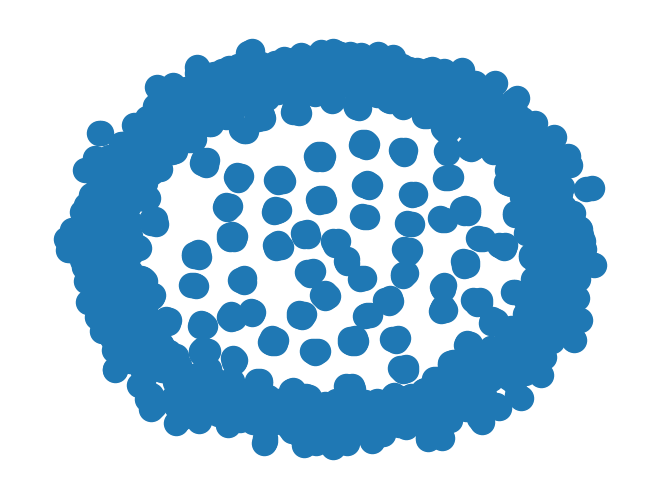

In [ ]:
nx.draw(G)

Gambar tersebut menunjukkan graf dasar untuk melihat struktur jaringan tanpa atribut tambahan.

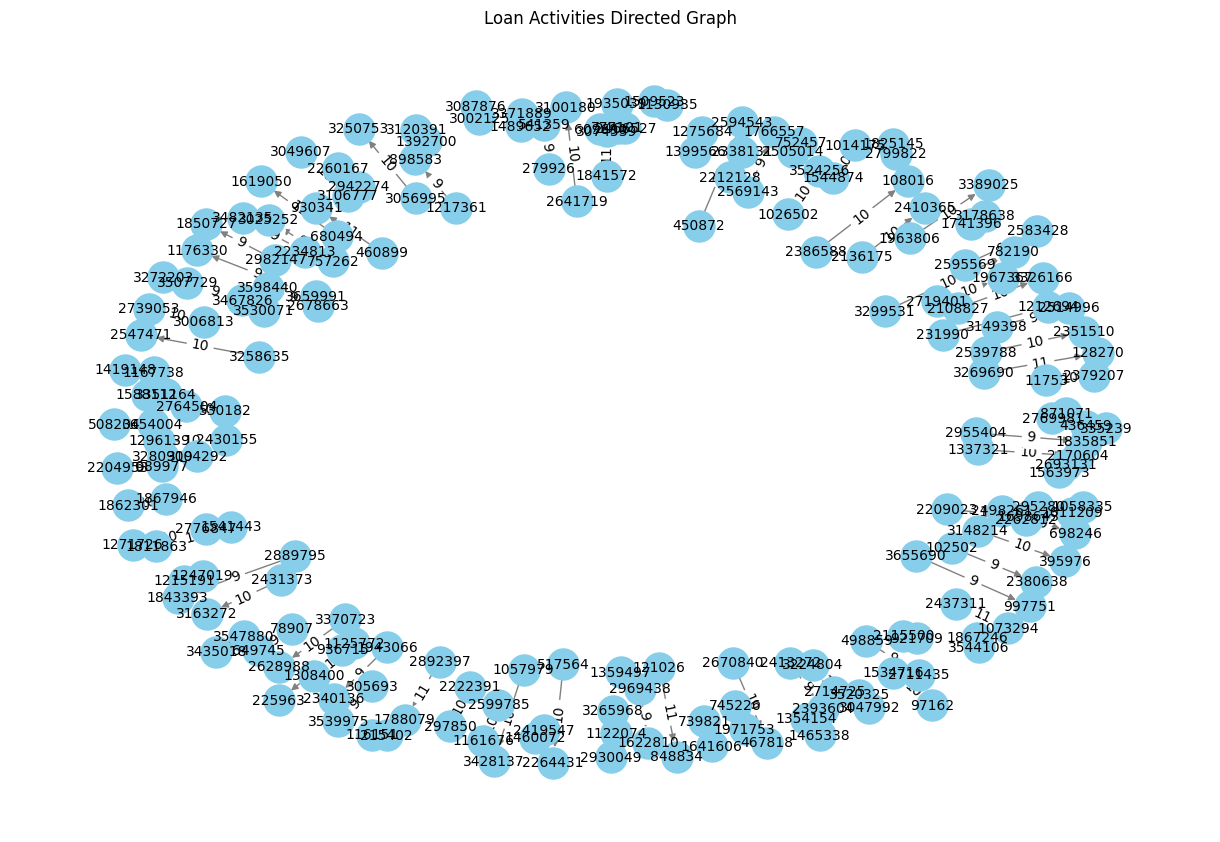

Visited node: 2419547
Visited node: 1460072
CPU times: user 2.03 s, sys: 380 ms, total: 2.41 s
Wall time: 2.17 s


In [ ]:
# Initialize a directed graph
%%time
G = nx.DiGraph()

# Add edges based on loan activities
for index, row in loan_df_sorted[:100].iterrows():
    user_id = row['user_id']
    reference_contact = row['reference_contact']
    loan_type = row['loan_type']
    ts = row['ts']

    # Add directed edge from user_id to reference_contact
    G.add_edge(user_id, reference_contact, loan_type=loan_type, timestamp=ts)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black', edge_color='gray')
labels = nx.get_edge_attributes(G, 'loan_type')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Loan Activities Directed Graph')
plt.show()

# Perform DFS traversal starting from a specific node
def dfs_traversal(graph, start_node):
    visited = set()
    stack = [start_node]
    while stack:
        node = stack.pop()
        if node not in visited:
            visited.add(node)
            print(f"Visited node: {node}")
            for neighbor in graph.neighbors(node):
                if neighbor not in visited:
                    stack.append(neighbor)

# Example usage:
start_node =  2419547 # Replace with your starting node
dfs_traversal(G, start_node)


Kemudian, kami memvisualisasikan jaringan pinjaman berdasarkan data user dan kontak referensi mereka, serta melakukan traversal Depth-First Search (DFS) untuk menelusuri jaringan mulai dari node tertentu.  Gambar menunjukkan visualisasi directed graph yang menunjukkan hubungan antar user berdasarkan aktivitas loan.

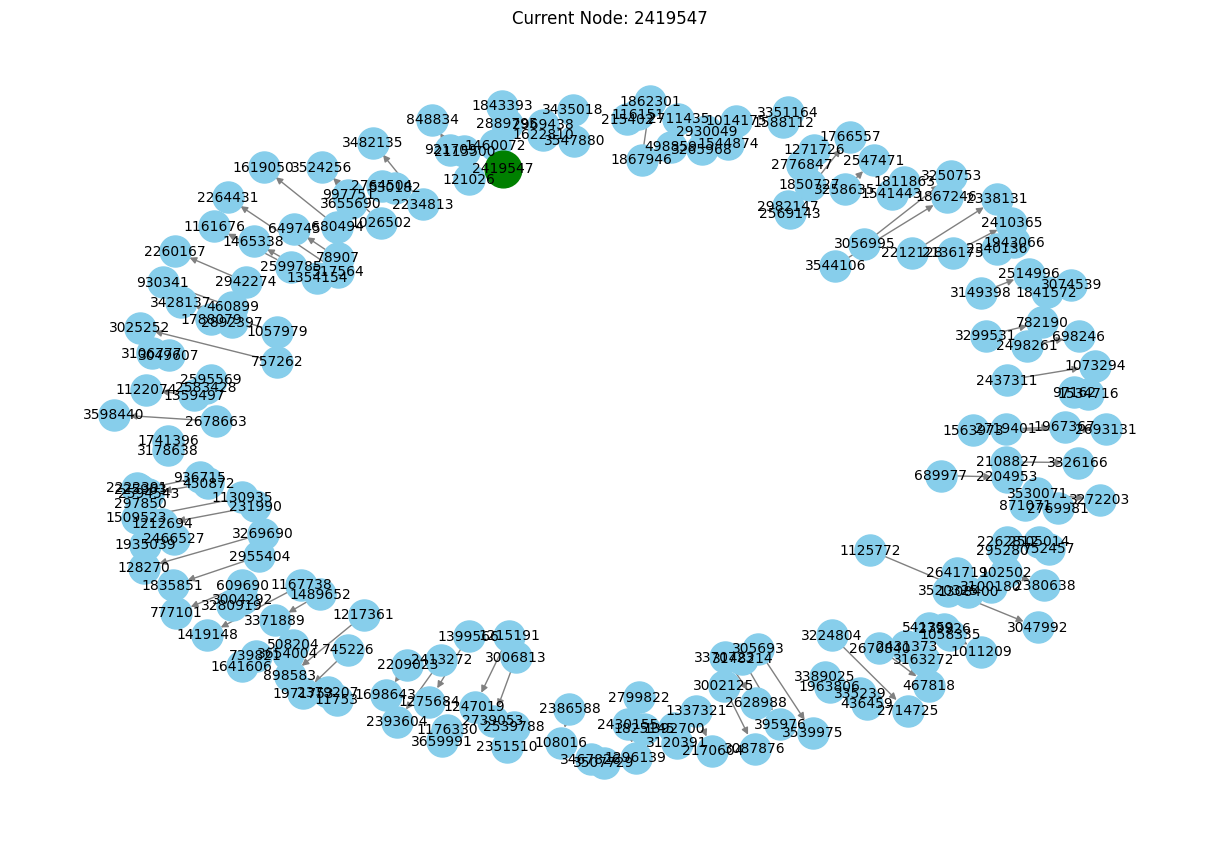

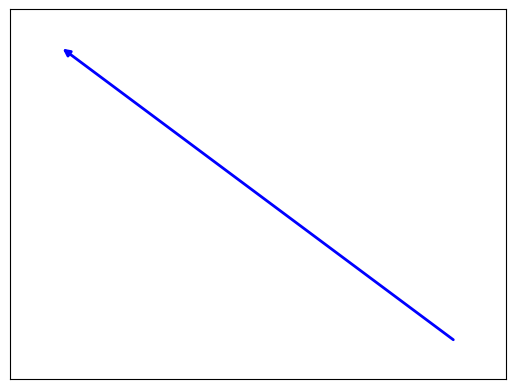

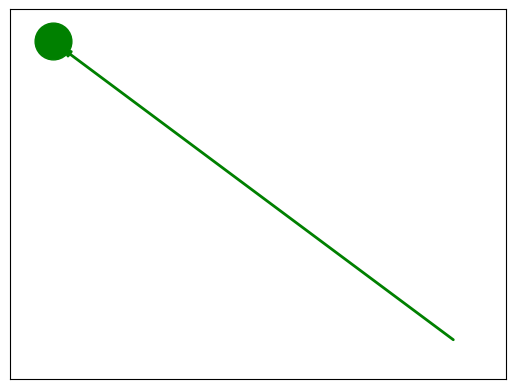

In [ ]:
from collections import deque
def visualize_bfs_traversal(graph, start_node):
    visited = set()
    queue = deque([(start_node, None)])  # (current_node, previous_node)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black', edge_color='gray')

    while queue:
        current_node, previous_node = queue.popleft()
        if current_node not in visited:
            visited.add(current_node)
            nx.draw_networkx_nodes(graph, pos, nodelist=[current_node], node_color='green', node_size=700)
            if previous_node:
                nx.draw_networkx_edges(graph, pos, edgelist=[(previous_node, current_node)], edge_color='green', width=2)
                plt.pause(1)  # pause briefly to visualize the traversal step
            plt.title(f'Current Node: {current_node}')
            plt.pause(0.5)  # pause briefly to visualize the node highlight
            for neighbor in graph.neighbors(current_node):
                if neighbor not in visited:
                    queue.append((neighbor, current_node))
                    nx.draw_networkx_edges(graph, pos, edgelist=[(current_node, neighbor)], edge_color='blue', width=2)
                    plt.pause(1)  # pause briefly to visualize the traversal step

    plt.title('BFS Traversal of Loan Activities Directed Graph')
    plt.show()

# Example usage:
start_node =  2419547 # Replace with your starting node
visualize_bfs_traversal(G, start_node)

Lalu, kami melakukan visualisasi traversal BFS.
Gambar pertama memberikan gambaran umum dari graf terarah yang digunakan untuk analisis aktivitas loan dengan node 2419547 sebagai titik awal.
Gambar kedua dan ketiga menunjukkan langkah awal dari traversal BFS, di mana node dan edge pertama sedang dieksplorasi.
Gambar keempat dan kelima merupakan indikasi bahwa traversal BFS sedang atau telah mencapai node yang tidak memiliki koneksi tambahan.

In [ ]:
loan_df_sorted[:10000]

user_id  reference_contact  loan_type  ts
0     2419547            1460072         10   1
1     3655690             997751          9   1
2     2942274            2260167         10   1
3     1217361             898583          9   1
4     3299531             782190         10   1
...       ...                ...        ...  ..
9995  2369773             104889          9   3
9996  3442075            1313457         10   3
9997  3562343             613134         11   3
9998  2163686            3237143         11   3
9999  1115075            2547379          9   3

[10000 rows x 4 columns]

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load data from loan_activities.csv
df = loan_df.copy()

# Initialize a directed graph
G = nx.DiGraph()

# Add edges based on loan activities
for index, row in loan_df_sorted[:1000].iterrows():
    user_id = row['user_id']
    reference_contact = row['reference_contact']
    loan_type = row['loan_type']
    ts = row['ts']

    # Add directed edge from user_id to reference_contact
    G.add_edge(user_id, reference_contact, loan_type=loan_type, timestamp=ts)

# Function to visualize connections of a specific user_id
def visualize_user_connections(G, user_id):
    if user_id not in G:
        print(f"User ID {user_id} not found in the graph.")
        return

    # Get all incoming and outgoing edges for the user_id
    incoming_edges = list(G.in_edges(user_id, data=True))
    outgoing_edges = list(G.out_edges(user_id, data=True))

    # Create a subgraph of the user's connections
    subgraph = nx.DiGraph()
    subgraph.add_edges_from(incoming_edges + outgoing_edges)

    # Draw the subgraph
    plt.figure(figsize=(5, 5))
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_color='black', edge_color='gray')
    edge_labels = nx.get_edge_attributes(subgraph, 'loan_type')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)
    plt.title(f'Connections for User ID: {user_id}')
    plt.show()

    # Display edge details
    print(f"User ID: {user_id}")
    print("\nIncoming Connections:")
    for edge in incoming_edges:
        print(f"From {edge[0]}: Loan Type: {edge[2]['loan_type']}, Timestamp: {edge[2]['timestamp']}")

    print("\nOutgoing Connections:")
    for edge in outgoing_edges:
        print(f"To {edge[1]}: Loan Type: {edge[2]['loan_type']}, Timestamp: {edge[2]['timestamp']}")

# Example usage: Replace 'example_user_id' with the actual user ID you want to explore
user_id_to_explore = 291091
visualize_user_connections(G, user_id_to_explore)


User ID: 291091

Incoming Connections:

Outgoing Connections:
To 747667: Loan Type: 9, Timestamp: 1
To 904444: Loan Type: 9, Timestamp: 1


Kami memvisualisasikan jaringan koneksi untuk user tertentu dengan membuat graf terarah (DiGraph) menggunakan NetworkX. Gambar menunjukkan visualisasi subgraf yang menunjukkan koneksi user dengan user_id 291091 berdasarkan data loan_activities,  dengan satu koneksi masuk dan satu koneksi keluar.

In [ ]:
loan_df_sorted[['user_id']][:1000].value_counts()

user_id
291091     2
530182     2
311        1
2533951    1
2555103    1
          ..
1367175    1
1368121    1
1370442    1
1372339    1
3691795    1
Name: count, Length: 998, dtype: int64

In [ ]:
loan_df_sorted

user_id  reference_contact  loan_type   ts
0        2419547            1460072         10    1
1        3655690             997751          9    1
2        2942274            2260167         10    1
3        1217361             898583          9    1
4        3299531             782190         10    1
...          ...                ...        ...  ...
4300994  2221485             811191          3  821
4300995  2981928            3291180          1  821
4300996  3554946            1139781          5  821
4300997  1012518             142880          5  821
4300998  1817392            2487290          5  821

[4300999 rows x 4 columns]

In [ ]:
# Initialize a directed graph
G = nx.DiGraph()

# Add edges based on user_id -> reference_contact relationship
for _, row in loan_df_sorted[:5000].iterrows():
    user_id = row['user_id']
    reference_contact = row['reference_contact']
    G.add_edge(user_id, reference_contact)

# Function to perform DFS traversal and print path
def traverse_user_contacts(graph, start_user_id):
    visited = set()
    stack = [(start_user_id, [start_user_id])]

    while stack:
        (vertex, path) = stack.pop()
        if vertex not in visited:
            visited.add(vertex)
            neighbors = list(graph.neighbors(vertex))
            for neighbor in neighbors:
                if neighbor not in visited:
                    new_path = path + [neighbor]
                    stack.append((neighbor, new_path))
                    print(f"Path: {' -> '.join(map(str, new_path))}")

# Starting user_id for traversal
start_user_id = 291091

# Perform DFS traversal from the starting user_id
if start_user_id in G.nodes:
    print(f"Starting traversal from user_id: {start_user_id}")
    traverse_user_contacts(G, start_user_id)
else:
    print(f"User ID {start_user_id} not found in the dataset.")

# Optionally, you can visualize the graph
# nx.draw(G, with_labels=True)
# plt.show()

Starting traversal from user_id: 291091
Path: 291091 -> 747667
Path: 291091 -> 904444
Path: 291091 -> 1376607


Kami membuat graf terarah (DiGraph) menggunakan NetworkX. Output menunjukkan jalur yang dilalui dari start_user_id ke node lainnya dalam graf berdasarkan hubungan user_id -> reference_contact.

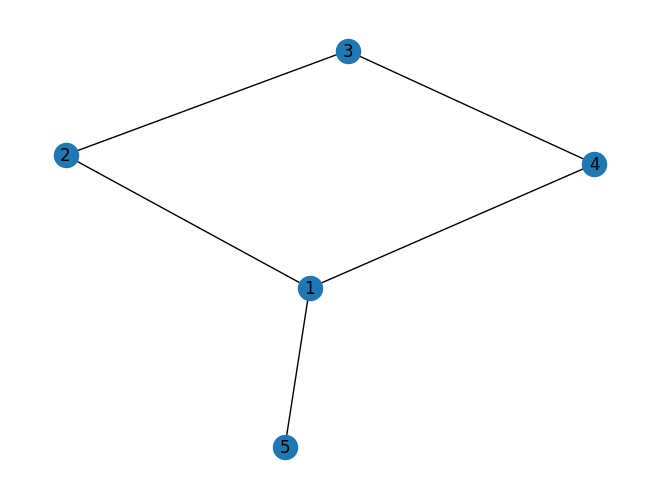

In [ ]:
g = nx.Graph()

g.add_edge(1, 2)
g.add_edge(2, 3)
g.add_edge(3, 4)
g.add_edge(1, 4)
g.add_edge(1, 5)

nx.draw(g, with_labels = True)

Kami membuat graf tidak terarah (undirected graph) menggunakan NetworkX. Struktur Graf yang diperoleh adalah:

*   Node 1 terhubung dengan node 2, 3, 4, dan 5.
*   Node 2 terhubung dengan node 1 dan 3.
* Node 3 terhubung dengan node 2, 1, dan 4.
* Node 4 terhubung dengan node 1 dan 3.
* Node 5 hanya terhubung dengan node 1.


In [ ]:
# Starting user_id for traversal
start_user_id = 1

# Perform DFS traversal from the starting user_id
if start_user_id in g.nodes:
    print(f"Starting traversal from user_id: {start_user_id}")
    traverse_user_contacts(g, start_user_id)
else:
    print(f"User ID {start_user_id} not found in the dataset.")

Starting traversal from user_id: 1
Path: 1 -> 2
Path: 1 -> 4
Path: 1 -> 5
Path: 1 -> 4 -> 3
Path: 1 -> 4 -> 3 -> 2


In [ ]:
G = nx.DiGraph()

# Add edges based on user_id -> reference_contact relationship
for _, row in loan_df_sorted[:1000].iterrows():
    user_id = row['user_id']
    reference_contact = row['reference_contact']
    G.add_edge(user_id, reference_contact)

# Function to perform DFS traversal using dfs_edges and print paths
def traverse_user_contacts(graph, start_user_id):
    if start_user_id not in graph:
        print(f"User ID {start_user_id} not found in the dataset.")
        return

    edges = list(nx.dfs_edges(graph, source=start_user_id))
    if not edges:
        print(f"No paths found starting from user_id: {start_user_id}")
        return

    paths = []
    current_path = [start_user_id]

    for u, v in edges:
        if u == current_path[-1]:
            current_path.append(v)
        else:
            paths.append(current_path.copy())
            while current_path and current_path[-1] != u:
                current_path.pop()
            current_path.append(v)

    paths.append(current_path)

    for path in paths:
        print(f"Path: {' -> '.join(map(str, path))}")

# Starting user_id for traversal
start_user_id = 2942274  # Replace with your actual starting user_id

# Perform DFS traversal from the starting user_id
print(f"Starting traversal from user_id: {start_user_id}")
traverse_user_contacts(G, start_user_id)

# Optionally, you can visualize the graph
# nx.draw(G, with_labels=True)
# plt.show()

Starting traversal from user_id: 2942274
Path: 2942274 -> 2260167


Kami membangun graf terarah dari data aktivitas pinjaman dan melakukan traversal DFS untuk mencetak jalur yang dilalui dari node awal 2942274. Hasil traversal menunjukkan jalur 2942274 -> 2260167, yang berarti 2942274 memiliki satu koneksi langsung ke 2260167. Ini menggambarkan bahwa node 2942274 terhubung langsung dengan node 2260167 dalam graf aktivitas pinjaman tersebut.

In [ ]:
loan_df[loan_df['ts']==1][:1000]

user_id  reference_contact  loan_type  ts
3825794  1010509               9280          9   1
3825816  2508597            3550595          9   1
3825925  1654964            1883859          9   1
3825982  1459506             670115          9   1
3826139   399791             851662          9   1
...          ...                ...        ...  ..
3912781  2024802            2339304          9   1
3912810  1385197            1884562          9   1
3912859  3670682             922679          9   1
3912925  1853700            3535160          9   1
3912932  2346687            2574197          9   1

[1000 rows x 4 columns]

In [ ]:
start_user_id = 1  # Replace with your actual starting user_id

# Perform DFS traversal from the starting user_id
print(f"Starting traversal from user_id: {start_user_id}")
traverse_user_contacts(g, start_user_id)

Starting traversal from user_id: 1
Path: 1 -> 2 -> 3 -> 4
Path: 1 -> 5


Kami melakukan traversal DFS dari user_id 1 dalam subset data loan_df dengan ts = 1. Hasil traversal menunjukkan jalur 1 -> 2 -> 3 -> 4 dan 1 -> 5, yang berarti 1 terhubung langsung dengan 2, yang kemudian terhubung dengan 3, dan seterusnya, serta 1 juga memiliki koneksi langsung ke 5. Ini menggambarkan hubungan antara node dalam graf berdasarkan aktivitas pinjaman dengan timestamp = 1.

Starting traversal from user_id: 291091


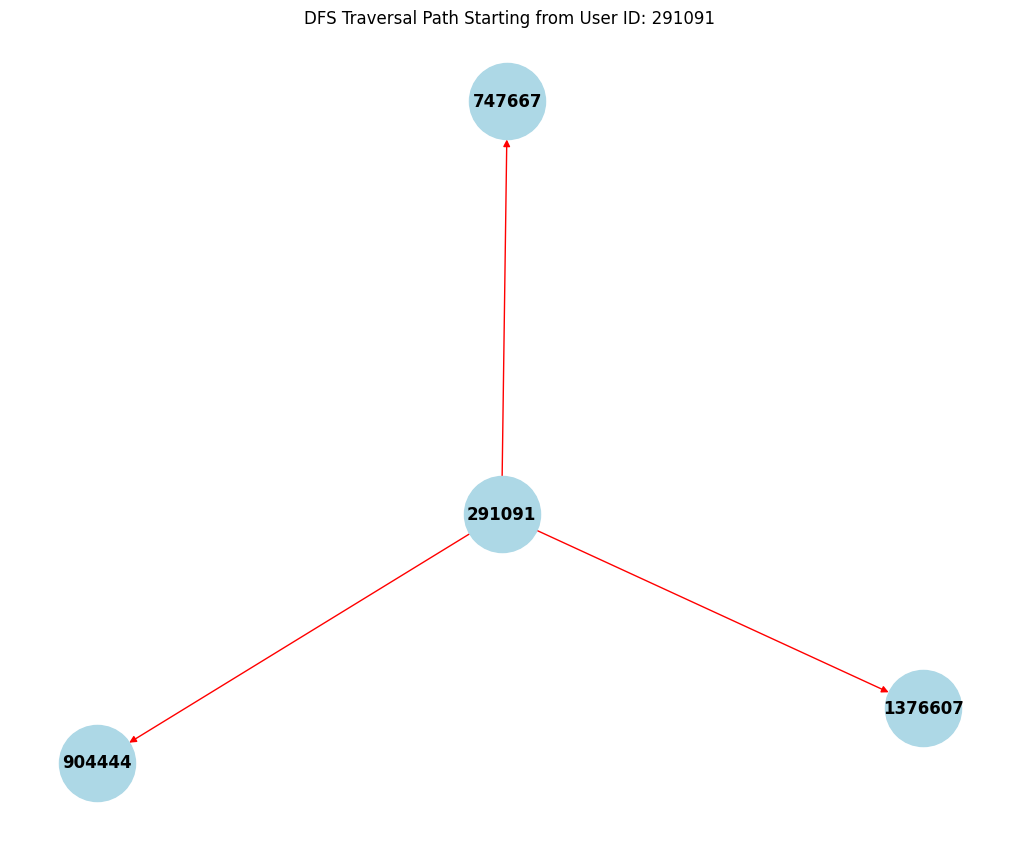

In [ ]:
import pandas as pd
import networkx as nx
G = nx.DiGraph()

# Add edges based on user_id -> reference_contact relationship
for _, row in loan_df_sorted[:5000].iterrows():
    user_id = row['user_id']
    reference_contact = row['reference_contact']
    G.add_edge(user_id, reference_contact)

# Function to perform DFS traversal using dfs_edges and return the traversed edges
def traverse_user_contacts(graph, start_user_id):
    if start_user_id not in graph:
        print(f"User ID {start_user_id} not found in the dataset.")
        return []

    edges = list(nx.dfs_edges(graph, source=start_user_id))
    if not edges:
        print(f"No paths found starting from user_id: {start_user_id}")
        return []

    return edges

# Starting user_id for traversal
start_user_id = 291091  # Replace with your actual starting user_id

# Perform DFS traversal from the starting user_id
print(f"Starting traversal from user_id: {start_user_id}")
traversal_edges = traverse_user_contacts(G, start_user_id)

# Create a subgraph with only the traversed nodes and edges
traversed_nodes = {start_user_id}  # Add the starting node
for u, v in traversal_edges:
    traversed_nodes.add(u)
    traversed_nodes.add(v)

traversed_graph = G.subgraph(traversed_nodes).copy()

# Visualize the traversed subgraph
pos = nx.spring_layout(traversed_graph)  # Positions for all nodes

plt.figure(figsize=(10, 8))
nx.draw(traversed_graph, pos, with_labels=True, node_color='lightblue', edge_color='red', node_size=3000, font_size=12, font_weight='bold')

plt.title(f"DFS Traversal Path Starting from User ID: {start_user_id}")
plt.show()


Gambar tersebut menunjukkan visualisasi jalur traversal DFS (Depth-First Search) dari user_id 291091 dalam graf yang terdiri dari node dan hubungan pinjaman antar node. Hasil traversal menunjukkan bahwa 291091 memiliki koneksi langsung ke 747667, 904444, dan 1376607. Visualisasi ini membantu untuk memahami pola koneksi dan interaksi pengguna dalam jaringan aktivitas pinjaman.

#EDA

In [ ]:
train_df['label'].value_counts().plot.pie(autopct='%1.3f%%', startangle=90, wedgeprops=dict(width=0.3))
plt.title('Distribution of fraud')

Text(0.5, 1.0, 'Distribution of fraud')

Dapat dilihat bahwa transaksi non-fraud merupakan mayoritas dengan persentase 98.734%. Sedangkan, transaksi fraud memiliki persentase hanya sebesar 1.266%. Dataset tidak seimbang, dengan sangat sedikitnya kasus fraud dibandingkan non-fraud. Maka, data imbalance ini akan ditangani pada bagian Imbalance dan Hyperparameter Tuning.

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(graph_train_df.corr(), annot=True, cmap='Reds')
plt.title('Correlation Matrix')
plt.show()

#Modelling

**Modelling** dalam *machine learning *untuk deteksi *fraud* memiliki peran yang  penting dalam mengidentifikasi aktivitas *fraud* dalam berbagai sistem. Proses ini melibatkan penggunaan algoritma untuk mengenali pola-pola dan anomali yang tidak mudah terdeteksi. Melalui pengenalan pola ini, model dapat memprediksi kemungkinan terjadinya *fraud* berdasarkan data historis, sehingga memungkinkan sistem untuk mendeteksi dan mencegah penipuan secara otomatis. Kami akan menggunakan beberapa metode dalam modelling ini, dengan tujuan untuk mendapat presisi terbaik dari beberapa metode yang kami pilih dalam *predicting fraud*

In [ ]:
SEED = 42

In [ ]:
X = graph_train_df.drop(['label'], axis = 1, inplace = False)
y = graph_train_df['label']
X

user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
0             3  1.0  1.0  0.275  0.255  0.927273  0.4  0.260  0.040  0.254   
1             5  0.0  0.0  0.430  0.365  0.848837  0.4  1.253  0.210  1.235   
2             9  1.0  3.0  1.315  0.825  0.627376  0.9  2.385  0.128  2.270   
3            10  0.0  5.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
4            17  1.0  1.0  0.235  0.160  0.680851  0.1  0.120  0.002  0.104   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
857894  3700529  1.0  4.0  0.190  0.160  0.842105  0.1  0.281  0.005  0.274   
857895  3700532  1.0  3.0  1.710  1.535  0.897661  2.1  3.750  0.687  3.712   
857896  3700537  1.0  0.0  2.165  2.060  0.951501  2.4  2.213  0.065  2.186   
857897  3700543  1.0  5.0  2.075  1.565  0.754217  1.9  3.292  0.342  3.188   
857898  3700548  0.0  4.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   

        ...  in_degree  out_degree  degree_centrality  \
0       ...          1           0       2.702302e-07   
1       ...          1           2       8.106905e-07   
2       ...          2           3       1.351151e-06   
3       ...          2           2       1.080921e-06   
4       ...          2           1       8.106905e-07   
...     ...        ...         ...                ...   
857894  ...          1           1       5.404603e-07   
857895  ...          0           3       8.106905e-07   
857896  ...          1           1       5.404603e-07   
857897  ...          0           1       2.702302e-07   
857898  ...          1           1       5.404603e-07   

        weighted_closeness_centrality_ts  weighted_closeness_centrality_lt  \
0                           5.237019e-10                      6.755754e-08   
1                           2.329570e-09                      2.702302e-07   
2                           5.122646e-09                      2.255024e-07   
3                           1.002916e-09                      1.158129e-07   
4                           2.290086e-09                      1.706717e-07   
...                                  ...                               ...   
857894                      8.008138e-10                      8.106905e-08   
857895                      0.000000e+00                      0.000000e+00   
857896                      1.055587e-09                      4.503836e-08   
857897                      0.000000e+00                      0.000000e+00   
857898                      8.606056e-10                      2.702302e-07   

        weighted_eigenvector_centrality_ts  \
0                             2.120712e-20   
1                             9.949168e-21   
2                             2.294677e-20   
3                            -4.392335e-19   
4                             2.025422e-20   
...                                    ...   
857894                        1.794876e-20   
857895                        1.447886e-20   
857896                        8.650153e-21   
857897                        1.565953e-20   
857898                        2.551650e-20   

        weighted_eigenvector_centrality_lt   pagerank_lt   pagerank_ts  \
0                             1.139716e-19  2.049298e-07  2.108195e-07   
1                             4.337696e-21  3.639498e-07  3.639498e-07   
2                            -8.735688e-21  3.926618e-07  2.923955e-07   
3                             4.331221e-20  5.170802e-07  4.787976e-07   
4                             2.356545e-20  2.950412e-07  4.243439e-07   
...                                    ...           ...           ...   
857894                        1.047786e-19  1.916782e-07  1.801934e-07   
857895                        5.348766e-21  1.342543e-07  1.342543e-07   
857896                        8.037710e-20  3.639498e-07  3.639498e-07   
857897                       -5.170415e-20  1.342543e-07  1.342543e-07   
857898                       -1.680707e-22  1.533956e-07  1.884017e-07

In [ ]:
y.value_counts()

label
0    847042
1     10857
Name: count, dtype: int64

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, random_state = SEED)
X_train

user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
547467  2363507  1.0  6.0  0.760  0.720  0.947368  0.8  0.928  0.100  0.910   
414388  1789199  1.0  3.0  0.245  0.225  0.918367  0.2  0.144  0.003  0.140   
188282   810686  0.0  2.0  0.385  0.325  0.844156  0.3  0.486  0.029  0.474   
336053  1450409  0.0  2.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
8185      35507  1.0  5.0  1.655  1.505  0.909366  0.6  0.561  0.015  0.525   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
575092  2483364  1.0  6.0  0.620  0.550  0.887097  0.1  0.454  0.265  0.434   
492366  2126392  1.0  4.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
697515  3010901  1.0  3.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
354525  1529252  0.0  4.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
233603  1008610  1.0  1.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   

        ...  in_degree  out_degree  degree_centrality  \
547467  ...          0           2       5.404603e-07   
414388  ...          0           2       5.404603e-07   
188282  ...          2           1       8.106905e-07   
336053  ...          1           0       2.702302e-07   
8185    ...          0           1       2.702302e-07   
...     ...        ...         ...                ...   
575092  ...          2           2       1.080921e-06   
492366  ...          1           0       2.702302e-07   
697515  ...          2           0       5.404603e-07   
354525  ...          1           0       2.702302e-07   
233603  ...          2           1       8.106905e-07   

        weighted_closeness_centrality_ts  weighted_closeness_centrality_lt  \
547467                      0.000000e+00                      0.000000e+00   
414388                      0.000000e+00                      0.000000e+00   
188282                      1.621381e-09                      2.026726e-07   
336053                      9.685669e-10                      5.404603e-08   
8185                        0.000000e+00                      0.000000e+00   
...                                  ...                               ...   
575092                      1.238956e-09                      1.216036e-07   
492366                      3.916379e-10                      6.755754e-08   
697515                      9.382992e-10                      1.201023e-07   
354525                      2.401453e-09                      1.144504e-07   
233603                      3.258693e-09                      1.854970e-07   

        weighted_eigenvector_centrality_ts  \
547467                        1.662093e-20   
414388                        1.696890e-20   
188282                        5.250777e-20   
336053                       -1.394833e-20   
8185                         -2.060110e-20   
...                                    ...   
575092                       -6.722313e-20   
492366                       -2.494499e-22   
697515                        3.457149e-21   
354525                       -1.932578e-20   
233603                        1.986511e-20   

        weighted_eigenvector_centrality_lt   pagerank_lt   pagerank_ts  \
547467                        1.067650e-20  1.342543e-07  1.342543e-07   
414388                        4.854386e-20  1.342543e-07  1.342543e-07   
188282                        1.469045e-19  3.830911e-07  4.389429e-07   
336053                        1.642893e-19  2.060341e-07  2.077463e-07   
8185                         -3.874599e-20  1.342543e-07  1.342543e-07   
...                                    ...           ...           ...   
575092                       -5.304849e-21  3.294204e-07  2.847748e-07   
492366                       -1.202712e-19  3.180107e-07  2.491021e-07   
697515                        1.367121e-19  4.787976e-07  4.747578e-07   
354525                        7.790019e-19  2.491021e-07  2.051480e-07   
233603                        2.822789e-19  4.450189e-07  3.922685e-07

In [ ]:
y_val.value_counts()

label
0    211761
1      2714
Name: count, dtype: int64

Berikut merupakan metode yang akan kami gunakan sebagai modelling-nya

In [ ]:
%%time
model_xgbc1 = xgb.XGBClassifier(random_state = SEED)
model_xgbc2 = make_pipeline(RobustScaler(), model_xgbc1)

model_xgbc2.fit(X_train, y_train)
display(model_xgbc2)
ap_proba = average_precision_score(y_val, model_xgbc2.predict_proba(X_val)[:, 1])
print(f"Average precision score (proba): {ap_proba}")

In [ ]:
models = {
    'Decision_Tree': tree.DecisionTreeClassifier(random_state = SEED),
    'logistic_regression' : linear_model.LogisticRegression(verbose = 0, random_state = SEED),
    'gradientboostingCla': ensemble.GradientBoostingClassifier(random_state = SEED),
    'xgboostCla': xgb.XGBClassifier(random_state = SEED),
    'catboostCla': cb.CatBoostClassifier(verbose=0, random_state = SEED),
    'lightgbmCla': lgbm.LGBMClassifier(random_state = SEED, silent=True, verbose = -1)
}

In [ ]:
models_gpu = {
    'xgboostCla': xgb.XGBClassifier(random_state = SEED, device = 'cuda'),
    'catboostCla': cb.CatBoostClassifier(verbose=0, random_state = SEED, task_type = 'GPU')
}

In [ ]:
def model_comparison(X, y, X_train, X_val, y_train, y_val, models, scaler):
    result = {"metric": ['ROC', "Accuracy","Average Precision", "Precision", "Recall", "f1 score"]}
    stratifiedkf = StratifiedKFold(n_splits=4, random_state = SEED, shuffle=True)

    for name, model in models.items():
        model2 = make_pipeline(scaler, model)
        print(model2)

        model2.fit(X_train, y_train)
        roc = roc_auc_score(y_val, model2.predict_proba(X_val)[:, 1])
        acc = accuracy_score(y_val, model2.predict(X_val))
        ap_proba = average_precision_score(y_val, model2.predict_proba(X_val)[:, 1])
        pre = precision_score(y_val, model2.predict(X_val))
        rec = recall_score(y_val, model2.predict(X_val))
        f1 = f1_score(y_val, model2.predict(X_val))

        result[name] = [roc, acc, ap_proba, pre, rec, f1]
    return pd.DataFrame(result)

In [ ]:
%%time
model_compar_1_gpu = model_comparison(X, y, X_train, X_val, y_train, y_val, models_gpu, RobustScaler())
model_compar_1_gpu

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device='cuda',
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_st

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



CPU times: user 39.1 s, sys: 11.3 s, total: 50.4 s
Wall time: 44.7 s


metric  xgboostCla  catboostCla
0                ROC    0.806826     0.810288
1           Accuracy    0.987323     0.987346
2  Average Precision    0.043368     0.046982
3          Precision    0.222222     0.000000
4             Recall    0.000737     0.000000
5           f1 score    0.001469     0.000000

In [ ]:
%%time
model_compar_1 = model_comparison(X, y, X_train, X_val, y_train, y_val, models)
model_compar_1

Pipeline(steps=[('nonetype', None),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])
Pipeline(steps=[('nonetype', None),
                ('logisticregression', LogisticRegression(random_state=42))])
Pipeline(steps=[('nonetype', None),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])
Pipeline(steps=[('nonetype', None),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=42))])
Pipeline(steps=[('nonetype', None),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(random_state=42))])
Pipeline(steps=[('nonetype', None),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
             

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pipeline(steps=[('nonetype', None),
                ('extratreesclassifier',
                 ExtraTreesClassifier(random_state=42))])
CPU times: user 30min 47s, sys: 9.96 s, total: 30min 57s
Wall time: 28min 24s


metric  Decision_Tree  logistic_regression  randomforestCla  \
0                   ROC       0.514148             0.678055         0.604087   
1              Accuracy       0.973265             0.987173         0.982212   
2              AP proba       0.013659             0.023672         0.021910   
3               AP pred       0.013659             0.012681         0.013239   
4             Precision       0.035956             0.048780         0.043154   
5                Recall       0.043110             0.000737         0.019160   
6              f1 score       0.039209             0.001452         0.026537   
7  cross_val_score_mean            NaN                  NaN              NaN   
8       Cross val score            NaN                  NaN              NaN   

   gradientboostingCla  HistGradientBoostingCla  xgboostCla  catboostCla  \
0             0.807916                 0.806374    0.805421     0.805011   
1             0.987309                 0.987187    0.987337     0.987323   
2             0.045992                 0.041444    0.044865     0.042845   
3             0.012686                 0.012654    0.012890     0.012654   
4             0.100000                 0.000000    0.333333     0.000000   
5             0.000368                 0.000000    0.000737     0.000000   
6             0.000734                 0.000000    0.001471     0.000000   
7                  NaN                      NaN         NaN          NaN   
8                  NaN                      NaN         NaN          NaN   

   lightgbmCla  AdaBoostCla  ExtraTreesCla  
0     0.806833     0.800650       0.579828  
1     0.986991     0.987346       0.982208  
2     0.040824     0.040624       0.019929  
3     0.012654     0.012654       0.013264  
4     0.012821     0.000000       0.043874  
5     0.000368     0.000000       0.019528  
6     0.000716     0.000000       0.027027  
7          NaN          NaN            NaN  
8          NaN          NaN            NaN

## Voting

Voting merupakan salah satu teknik untuk meningkatkan akurasi. Teknik ensemble voting menggabungkan hasil prediksi dari beberapa model berbeda, seperti XGBoost, Catboost, dan GradienBoostingCLA, untuk mencapai konsensus yang lebih andal dalam *predicting* dalam *machine learning*. Voting juga membantu dalam mengatasi kelemahan individual dari masing-masing model, sehingga memberikan prediksi yang lebih stabil dan konsisten dari waktu ke waktu.

Kami akan menggunakan XGBoost, Catboost, GradienBoostingCLA, AdaBoostCLA, dan HistGradientBoostingCLA sebagai metode Voting

In [ ]:
##Voting

%%time
estimator = [
    #('randomforestCla', ensemble.RandomForestClassifier(random_state=SEED)),
    ('gradientboostingCla', ensemble.GradientBoostingClassifier(random_state=SEED)),
    ('histgradientboostingCla', ensemble.HistGradientBoostingClassifier(random_state=SEED)),
    ('xgboostCla', xgb.XGBClassifier(random_state=SEED)),
    ('catboostCla', cb.CatBoostClassifier(verbose=0, random_state=SEED)),
    #('lightgbmCla', lgbm.LGBMClassifier(random_state = SEED, silent=True, verbose = -1)),
    ('AdaBoostCla', ensemble.AdaBoostClassifier(random_state = SEED)),
    #('ExtraTreesCla', ensemble.ExtraTreesClassifier(random_state = SEED)),

]

voting_clf = VotingClassifier(estimators = estimator, voting='soft')
voting_clf2 = make_pipeline(RobustScaler(), voting_clf)

voting_clf2.fit(X_train, y_train)
display(voting_clf2)
ap_proba = average_precision_score(y_val, voting_clf2.predict_proba(X_val)[:, 1])
ap_pred = average_precision_score(y_val, voting_clf2.predict(X_val))
print(f"Average precision score (proba): {ap_proba}")
print(f"Average precision score (pred): {ap_pred}")
print(f"Average precision score (pred macro): {ap_pred}")
#0.04054470350195011.

# Feature selection

Untuk meningkatkan tingkat akurasi (AP Precision), kami akan melakukan *feature selection *lebih dalam

In [ ]:
X_train

user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  \
547467  2363507  1.0  6.0  0.760  0.720  0.947368  0.8  0.928  0.100  0.910   
414388  1789199  1.0  3.0  0.245  0.225  0.918367  0.2  0.144  0.003  0.140   
188282   810686  0.0  2.0  0.385  0.325  0.844156  0.3  0.486  0.029  0.474   
336053  1450409  0.0  2.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
8185      35507  1.0  5.0  1.655  1.505  0.909366  0.6  0.561  0.015  0.525   
...         ...  ...  ...    ...    ...       ...  ...    ...    ...    ...   
575092  2483364  1.0  6.0  0.620  0.550  0.887097  0.1  0.454  0.265  0.434   
492366  2126392  1.0  4.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
697515  3010901  1.0  3.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
354525  1529252  0.0  4.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   
233603  1008610  1.0  1.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000   

        ...  in_degree  out_degree  degree_centrality  \
547467  ...          0           2       5.404603e-07   
414388  ...          0           2       5.404603e-07   
188282  ...          2           1       8.106905e-07   
336053  ...          1           0       2.702302e-07   
8185    ...          0           1       2.702302e-07   
...     ...        ...         ...                ...   
575092  ...          2           2       1.080921e-06   
492366  ...          1           0       2.702302e-07   
697515  ...          2           0       5.404603e-07   
354525  ...          1           0       2.702302e-07   
233603  ...          2           1       8.106905e-07   

        weighted_closeness_centrality_ts  weighted_closeness_centrality_lt  \
547467                      0.000000e+00                      0.000000e+00   
414388                      0.000000e+00                      0.000000e+00   
188282                      1.621381e-09                      2.026726e-07   
336053                      9.685669e-10                      5.404603e-08   
8185                        0.000000e+00                      0.000000e+00   
...                                  ...                               ...   
575092                      1.238956e-09                      1.216036e-07   
492366                      3.916379e-10                      6.755754e-08   
697515                      9.382992e-10                      1.201023e-07   
354525                      2.401453e-09                      1.144504e-07   
233603                      3.258693e-09                      1.854970e-07   

        weighted_eigenvector_centrality_ts  \
547467                        1.662093e-20   
414388                        1.696890e-20   
188282                        5.250777e-20   
336053                       -1.394833e-20   
8185                         -2.060110e-20   
...                                    ...   
575092                       -6.722313e-20   
492366                       -2.494499e-22   
697515                        3.457149e-21   
354525                       -1.932578e-20   
233603                        1.986511e-20   

        weighted_eigenvector_centrality_lt   pagerank_lt   pagerank_ts  \
547467                        1.067650e-20  1.342543e-07  1.342543e-07   
414388                        4.854386e-20  1.342543e-07  1.342543e-07   
188282                        1.469045e-19  3.830911e-07  4.389429e-07   
336053                        1.642893e-19  2.060341e-07  2.077463e-07   
8185                         -3.874599e-20  1.342543e-07  1.342543e-07   
...                                    ...           ...           ...   
575092                       -5.304849e-21  3.294204e-07  2.847748e-07   
492366                       -1.202712e-19  3.180107e-07  2.491021e-07   
697515                        1.367121e-19  4.787976e-07  4.747578e-07   
354525                        7.790019e-19  2.491021e-07  2.051480e-07   
233603                        2.822789e-19  4.450189e-07  3.922685e-07

Kami menggunakan *feature selection* menggunakan Catboost Classifier

In [ ]:
%%time
model_cb = cb.CatBoostClassifier(verbose=0, random_state = SEED, task_type = 'GPU')
model_cb.fit(X_train, y_train)
predictions = model_cb.predict_proba(X_val)
average_precision_score(y_val, predictions[:, 1])

CPU times: user 19.1 s, sys: 8.61 s, total: 27.7 s
Wall time: 21.4 s


0.04698127130547203

In [ ]:
rfe_dict1 = model_cb.select_features(X = X_train,
                                 y = y_train,
                                  eval_set = (X_val,y_val), # Walkforward validation set we have created earlier
                                  features_for_select = '0-43', # Features that will be selected on the RFE
                                  num_features_to_select = 33, # Number of features to keep from the selected
                                  steps = 10, # Number of model iterations performed in the RFE
                                  verbose = 50, #
                                  algorithm = EFeaturesSelectionAlgorithm.RecursiveByShapValues,
                                     train_final_model = False, # Train final model after RFE is finished
                                     plot = True # plot the ??? after the RFE is finished
                                     )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.041096
Step #1 out of 10
0:	learn: 0.5986355	test: 0.5986750	best: 0.5986750 (0)	total: 19.1ms	remaining: 19.1s
50:	learn: 0.0620474	test: 0.0625312	best: 0.0625312 (50)	total: 713ms	remaining: 13.3s
100:	learn: 0.0594259	test: 0.0601870	best: 0.0601870 (100)	total: 1.32s	remaining: 11.8s
150:	learn: 0.0589083	test: 0.0598534	best: 0.0598534 (150)	total: 1.91s	remaining: 10.7s
200:	learn: 0.0586653	test: 0.0597558	best: 0.0597558 (200)	total: 2.49s	remaining: 9.89s
250:	learn: 0.0584564	test: 0.0596794	best: 0.0596794 (250)	total: 3.06s	remaining: 9.13s
300:	learn: 0.0582465	test: 0.0596165	best: 0.0596165 (300)	total: 3.65s	remaining: 8.46s
350:	learn: 0.0580635	test: 0.0595777	best: 0.0595777 (350)	total: 4.24s	remaining: 7.85s
400:	learn: 0.0579021	test: 0.0595443	best: 0.0595433 (397)	total: 4.82s	remaining: 7.2s
450:	learn: 0.0577376	test: 0.0595247	best: 0.0595247 (449)	total: 5.43s	remaining: 6.61s
500:	learn: 0.0575883	test: 0.0595057	best: 0.0595045 (499

In [ ]:
rfe_dict1

{'selected_features': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  15,
  16,
  17,
  18,
  20,
  21,
  22,
  23,
  25,
  26,
  27,
  31,
  34,
  35,
  36,
  37,
  38,
  40,
  41,
  42],
 'eliminated_features_names': ['user_id',
  'pc13',
  'reference_contact_sum',
  'weighted_eigenvector_centrality_ts',
  'loan_type_sum',
  'reference_contact_max',
  'reference_contact_mean',
  'reference_contact_count',
  'degree',
  'common_contacts',
  'ts_sum'],
 'loss_graph': {'main_indices': [0, 1, 2, 4, 5, 6, 7, 8, 9, 10],
  'removed_features_count': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  'loss_values': [0.05939681650493331,
   0.05930177940561309,
   0.059261633360851856,
   0.0592542905963629,
   0.05925155561018907,
   0.05925796051452307,
   0.05920047445308807,
   0.059203901964264935,
   0.0592461568457367,
   0.05922717928791065,
   0.059258922938405234,
   0.05925593551520229]},
 'eliminated_features': [0, 14, 29, 39, 19, 32, 30, 28, 33, 43, 24],
 'selected_fe

Berikut terdapat feature yang terpilih

In [ ]:
selected_features_names_base = ['pc0',
  'pc1',
  'pc2',
  'pc3',
  'pc4',
  'pc5',
  'pc6',
  'pc7',
  'pc11',
  'pc15',
  'degree',
  'loan_type_mean',
  'loan_type_min',
  'loan_type_max',
  'ts_count',
  'ts_mean',
  'ts_min',
  'ts_max']


In [ ]:
X_train[selected_features_names_base]

pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7      pc11  \
547467  1.0  6.0  0.760  0.720  0.947368  0.8  0.928  0.100  0.052632   
414388  1.0  3.0  0.245  0.225  0.918367  0.2  0.144  0.003  0.081633   
188282  0.0  2.0  0.385  0.325  0.844156  0.3  0.486  0.029  0.155844   
336053  0.0  2.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000000   
8185    1.0  5.0  1.655  1.505  0.909366  0.6  0.561  0.015  0.090634   
...     ...  ...    ...    ...       ...  ...    ...    ...       ...   
575092  1.0  6.0  0.620  0.550  0.887097  0.1  0.454  0.265  0.112903   
492366  1.0  4.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000000   
697515  1.0  3.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000000   
354525  0.0  4.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000000   
233603  1.0  1.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000000   

            pc15  degree  loan_type_mean  loan_type_min  loan_type_max  \
547467  0.006579       2             3.5            1.0            6.0   
414388 -1.000000       2             5.0            4.0            6.0   
188282 -1.000000       3             5.0            5.0            5.0   
336053 -1.000000       1            -1.0           -1.0           -1.0   
8185    0.003021       1             4.0            4.0            4.0   
...          ...     ...             ...            ...            ...   
575092 -1.000000       4             4.5            4.0            5.0   
492366 -1.000000       1            -1.0           -1.0           -1.0   
697515 -1.000000       2            -1.0           -1.0           -1.0   
354525 -1.000000       1            -1.0           -1.0           -1.0   
233603 -1.000000       3             5.0            5.0            5.0   

        ts_count  ts_mean  ts_min  ts_max  
547467       2.0    299.0   299.0   299.0  
414388       2.0    658.0   528.0   788.0  
188282       1.0    205.0   205.0   205.0  
336053      -1.0     -1.0    -1.0    -1.0  
8185         1.0    708.0   708.0   708.0  
...          ...      ...     ...     ...  
575092       2.0    179.0   179.0   179.0  
492366      -1.0     -1.0    -1.0    -1.0  
697515      -1.0     -1.0    -1.0    -1.0  
354525      -1.0     -1.0    -1.0    -1.0  
233603       1.0    210.0   210.0   210.0  

[643424 rows x 18 columns]

Kami memilih untuk membuat feature kedua dengan tujuan meningkatkan nilai dari AP Precisionnya, dengan menambahkan hasil feature selection sebelumnya dengan hasil dari *graph features* dan *preprocessing*

In [ ]:
selected_features_names_1 = ['pc0',
  'pc1',
  'pc2',
  'pc3',
  'pc4',
  'pc5',
  'pc6',
  'pc7',
  'pc8',
  'pc9',
  'pc10',
  'pc11',
  'pc12',
  'pc14',
  'pc15',
  'pc16',
  'loan_type_count',
  'loan_type_mean',
  'loan_type_min',
  'loan_type_max',
  'ts_count',
  'ts_mean',
  'ts_min',
  'ts_max',
  'reference_contact_min',
  'in_degree',
  'out_degree',
  'degree_centrality',
  'weighted_closeness_centrality_ts',
  'weighted_closeness_centrality_lt',
  'weighted_eigenvector_centrality_lt',
  'pagerank_lt',
  'pagerank_ts']

In [ ]:
X_train[selected_features_names_1]

pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8       pc9  \
547467  1.0  6.0  0.760  0.720  0.947368  0.8  0.928  0.100  0.910  0.980603   
414388  1.0  3.0  0.245  0.225  0.918367  0.2  0.144  0.003  0.140  0.972222   
188282  0.0  2.0  0.385  0.325  0.844156  0.3  0.486  0.029  0.474  0.975309   
336053  0.0  2.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000 -1.000000   
8185    1.0  5.0  1.655  1.505  0.909366  0.6  0.561  0.015  0.525  0.935829   
...     ...  ...    ...    ...       ...  ...    ...    ...    ...       ...   
575092  1.0  6.0  0.620  0.550  0.887097  0.1  0.454  0.265  0.434  0.955947   
492366  1.0  4.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000 -1.000000   
697515  1.0  3.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000 -1.000000   
354525  0.0  4.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000 -1.000000   
233603  1.0  1.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000 -1.000000   

        ...  ts_max  reference_contact_min  in_degree  out_degree  \
547467  ...   299.0              1506615.0          0           2   
414388  ...   788.0              1936455.0          0           2   
188282  ...   205.0              1439528.0          2           1   
336053  ...    -1.0                   -1.0          1           0   
8185    ...   708.0               184538.0          0           1   
...     ...     ...                    ...        ...         ...   
575092  ...   179.0              1338802.0          2           2   
492366  ...    -1.0                   -1.0          1           0   
697515  ...    -1.0                   -1.0          2           0   
354525  ...    -1.0                   -1.0          1           0   
233603  ...   210.0              1588918.0          2           1   

        degree_centrality  weighted_closeness_centrality_ts  \
547467       5.404603e-07                      0.000000e+00   
414388       5.404603e-07                      0.000000e+00   
188282       8.106905e-07                      1.621381e-09   
336053       2.702302e-07                      9.685669e-10   
8185         2.702302e-07                      0.000000e+00   
...                   ...                               ...   
575092       1.080921e-06                      1.238956e-09   
492366       2.702302e-07                      3.916379e-10   
697515       5.404603e-07                      9.382992e-10   
354525       2.702302e-07                      2.401453e-09   
233603       8.106905e-07                      3.258693e-09   

        weighted_closeness_centrality_lt  weighted_eigenvector_centrality_lt  \
547467                      0.000000e+00                        1.067650e-20   
414388                      0.000000e+00                        4.854386e-20   
188282                      2.026726e-07                        1.469045e-19   
336053                      5.404603e-08                        1.642893e-19   
8185                        0.000000e+00                       -3.874599e-20   
...                                  ...                                 ...   
575092                      1.216036e-07                       -5.304849e-21   
492366                      6.755754e-08                       -1.202712e-19   
697515                      1.201023e-07                        1.367121e-19   
354525                      1.144504e-07                        7.790019e-19   
233603                      1.854970e-07                        2.822789e-19   

         pagerank_lt   pagerank_ts  
547467  1.342543e-07  1.342543e-07  
414388  1.342543e-07  1.342543e-07  
188282  3.830911e-07  4.389429e-07  
336053  2.060341e-07  2.077463e-07  
8185    1.342543e-07  1.342543e-07  
...              ...           ...  
575092  3.294204e-07  2.847748e-07  
492366  3.180107e-07  2.491021e-07  
697515  4.787976e-07  4.747578e-07  
354525  2.491021e-07  2.051480e-07  
233603  4.450189e-07  3.922685e-07  

[643424 rows x 33 columns]

Terlihat bahwa terdapat peningkatan nilai

In [ ]:
%%time
model_cb = cb.CatBoostClassifier(verbose=0, random_state = SEED, task_type = 'GPU'
                                 )
model_cb.fit(X_train[selected_features_names_1], y_train)
predictions = model_cb.predict_proba(X_val[selected_features_names_1])
average_precision_score(y_val, predictions[:, 1])

CPU times: user 18.6 s, sys: 8.56 s, total: 27.2 s
Wall time: 23.6 s


0.048072062394901915

In [ ]:
%%time
model_compar_rfe_gpu = model_comparison(X, y, X_train[selected_features_names_1],
                                    X_val[selected_features_names_1], y_train, y_val, models_gpu, RobustScaler())
model_compar_rfe_gpu

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device='cuda',
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_st

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



CPU times: user 29.5 s, sys: 8.54 s, total: 38.1 s
Wall time: 28.4 s


metric  xgboostCla  catboostCla
0                ROC    0.808481     0.811933
1           Accuracy    0.987327     0.987346
2  Average Precision    0.044494     0.048119
3          Precision    0.250000     0.000000
4             Recall    0.000737     0.000000
5           f1 score    0.001470     0.000000

In [ ]:
%%time
model_cb = cb.CatBoostClassifier(verbose=0, random_state = SEED, task_type = 'GPU'
                                 )
model_cb.fit(X_train[selected_features_names_base], y_train)
predictions = model_cb.predict_proba(X_val[selected_features_names_base])
average_precision_score(y_val, predictions[:, 1])

CPU times: user 14.7 s, sys: 6.89 s, total: 21.6 s
Wall time: 15.3 s


0.04797612535767393

In [ ]:
%%time
#Hasil kedua model setelah dilakukan feature selection
model_compar_rfe_gpu = model_comparison(X, y, X_train[selected_features_names_base],
                                    X_val[selected_features_names_base], y_train, y_val, models_gpu, RobustScaler())
model_compar_rfe_gpu

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device='cuda',
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_st

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



CPU times: user 25.6 s, sys: 8.22 s, total: 33.8 s
Wall time: 26.1 s


metric  xgboostCla  catboostCla
0                ROC    0.807342     0.813360
1           Accuracy    0.987341     0.987346
2  Average Precision    0.044033     0.048079
3          Precision    0.333333     0.000000
4             Recall    0.000368     0.000000
5           f1 score    0.000736     0.000000

# Imblearn

 imblearn memiliki peran  dalam meningkatkan kemampuan dalam menghadapi tantangan dataset yang tidak seimbang. Dalam konteks ini, imblearn menyediakan berbagai teknik resampling seperti oversampling  dan undersampling, yang membantu menyeimbangkan proporsi antara transaksi normal dan *fraud* yang jarang terjadi. Dengan mengatasi ketidakseimbangan ini, diharapkan dapat mengoptimalkan pengenalan pola dan prediksi.

In [ ]:
over_methods = [
    ADASYN(random_state=SEED),
    BorderlineSMOTE(random_state=SEED),
    RandomOverSampler(random_state=SEED),
    SMOTE(random_state=SEED),
    SVMSMOTE(random_state=SEED),
]

In [ ]:
def over_sampling_comparison(X_train, y_train, classifier, over_methods, scaler, y_val = y_val, X_val = X_val):
  result = {"metric": ["roc score", "ap score"]}
  for method in over_methods:
    X_train_resampled, y_train_resampled = method.fit_resample(X_train, y_train)
    print(method)
    print(X_train_resampled.shape, y_train_resampled.shape)
    print(y_train_resampled.value_counts())

    model2 = Pipeline(steps=[
    ("scaler", scaler), ('classifier', classifier)])
    print(classifier)

    classifier.fit(X_train_resampled, y_train_resampled)
    roc = roc_auc_score(y_val, classifier.predict_proba(X_val)[:, 1])
    ap = average_precision_score(y_val, classifier.predict_proba(X_val)[:, 1])
    print(ap)
    result[method] = [roc, ap]
    print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

  return pd.DataFrame(result)


In [ ]:
%%time
result_over_sample = over_sampling_comparison(cupy.array(X_train[selected_features_names_1]).get(), y_train,
                                                xgb.XGBClassifier(random_state = SEED, device = 'cuda'),
                                               over_methods, RobustScaler(), y_val,
                                               cupy.array(X_val[selected_features_names_1]).get())
result_over_sample

In [ ]:
models = {
    'Decision_Tree': tree.DecisionTreeClassifier(random_state = SEED),
    'logistic_regression' : linear_model.LogisticRegression(verbose = 0, random_state = SEED),
    'gradientboostingCla': ensemble.GradientBoostingClassifier(random_state = SEED),
    'xgboostCla': xgb.XGBClassifier(random_state = SEED),
    'catboostCla': cb.CatBoostClassifier(verbose=0, random_state = SEED),
    'lightgbmCla': lgbm.LGBMClassifier(random_state = SEED, silent=True, verbose = -1)
}

In [ ]:
def model_comparison_imbl(X, y, X_train, y_train, models, samp, scaler, X_val, y_val ):
    result = {"metric": ['ROC', "AP proba", "Accuracy", "Precision", "Recall", "f1 score"]}
    stratifiedkf = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)

    for name, model in models.items():
        model2 = ImbPipeline(steps=[('over', samp),
        ("scaler", scaler),
        ('classifier', model)
        ])

        print(model2)
        model2.fit(X_train, y_train)
        roc = roc_auc_score(y_val, model2.predict_proba(X_val)[:, 1])
        ap = average_precision_score(y_val, model2.predict_proba(X_val)[:, 1])
        acc = accuracy_score(y_val, model2.predict(X_val))
        pre = precision_score(y_val, model2.predict(X_val))
        rec = recall_score(y_val, model2.predict(X_val))
        f1 = f1_score(y_val, model2.predict(X_val))

        result[name] = [roc, ap, acc, pre, rec, f1]
    return pd.DataFrame(result)

In [ ]:
# hasil model setelah dilakukan random over sampling
%%time
model_compar_ros_gpu = model_comparison_imbl(X, y, X_train[selected_features_names_1], y_train,
                                           models_gpu, RandomOverSampler(random_state = SEED),
                                           RobustScaler(), X_val[selected_features_names_1], y_val,)
model_compar_ros_gpu

Pipeline(steps=[('over', RandomOverSampler(random_state=42)),
                ('scaler', RobustScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device='cuda',
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
             

metric  xgboostCla  catboostCla
0        ROC    0.803676     0.814052
1   AP proba    0.045296     0.047272
2   Accuracy    0.752540     0.720289
3  Precision    0.035047     0.034235
4     Recall    0.699337     0.775608
5   f1 score    0.066749     0.065575

# Hyperparameter Tuning

*Hyperparameter tuning* memiliki peran dalam mengoptimalkan kinerja model *machine learning*. Proses *tuning hyperparameter* memungkinkan penyesuaian yang tepat terhadap parameter-parameter seperti learning rate, jumlah estimators pada ensemble models, depth of trees, dan parameter lainnya yang mempengaruhi kemampuan model dalam mengenali pola-pola penipuan yang kompleks. Dengan menyesuaikan *hyperparameter* secara optimal, sistem dapat mengurangi risiko *overfitting* atau *underfitting*. Hal ini tidak hanya meningkatkan akurasitetapi juga meningkatkan generalisasi model terhadap data baru. Kami akan menggunakan XGB dan Catboost untuk menentukan *best hyperparameter* untuk model kami

## XGB

In [ ]:
#Model xgb sebelum hyperparameter tuning
model = ImbPipeline(steps=[('over', RandomOverSampler()),
    ("scaler", RobustScaler()), ('classifier', xgb.XGBClassifier(random_state = SEED, device= 'cuda'))
    ])

model.fit(X_train[selected_features_names_1], y_train)

y_pred_proba = model.predict_proba(X_val[selected_features_names_1])[:, 1]
avg_precision = average_precision_score(y_val, y_pred_proba)

avg_precision

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [13:21:54] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.045297018889868146

In [ ]:
import joblib

In [ ]:
%%time
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'lambda': trial.suggest_float('lambda', 1e-3, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    trial_shrinkage = trial.suggest_float('trial_shrinkage', 0, 10)
    sampler = RandomOverSampler(random_state=SEED, shrinkage=trial_shrinkage)

    model = ImbPipeline(steps=[('over', sampler),
    ("scaler", RobustScaler()), ('classifier', xgb.XGBClassifier(**param, random_state = SEED, device = 'cuda'))
    ])

    model.fit(X_train[selected_features_names_1], y_train)

    y_pred_proba = model.predict_proba(X_val[selected_features_names_1])[:, 1]
    avg_precision = average_precision_score(y_val, y_pred_proba)

    return avg_precision

# Create a study and optimize the objective function
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=150)

# Save the study
joblib.dump(study, '/content/drive/MyDrive/Datathon 2024_DMR/Lomba/optuna_study_checkpoint_xgb.pkl')

# Get the best hyperparameters
best_params_xgbcl = study.best_params
print("Best hyperparameters: ", best_params_xgbcl)

[I 2024-07-14 13:22:26,565] A new study created in memory with name: no-name-448f086c-0879-403a-845a-6fa847cea6d0
[I 2024-07-14 13:22:41,290] Trial 0 finished with value: 0.03782059490926647 and parameters: {'lambda': 0.013292918943162165, 'alpha': 0.711447600934342, 'subsample': 0.839196365086843, 'colsample_bytree': 0.759195090518222, 'learning_rate': 0.047649573492288516, 'n_estimators': 240, 'max_depth': 3, 'min_child_weight': 9, 'trial_shrinkage': 6.011150117432088}. Best is trial 0 with value: 0.03782059490926647.
[I 2024-07-14 13:22:56,171] Trial 1 finished with value: 0.04604604793681049 and parameters: {'lambda': 0.13311216080736885, 'alpha': 0.00115279871282324, 'subsample': 0.9819459112971965, 'colsample_bytree': 0.899465584480253, 'learning_rate': 0.06448939409280458, 'n_estimators': 263, 'max_depth': 4, 'min_child_weight': 4, 'trial_shrinkage': 5.247564316322379}. Best is trial 1 with value: 0.04604604793681049.
[I 2024-07-14 13:23:14,311] Trial 2 finished with value: 0.04

Best hyperparameters:  {'lambda': 0.0016521011582881452, 'alpha': 0.0012805961870647527, 'subsample': 0.6790452615090394, 'colsample_bytree': 0.8052874523142316, 'learning_rate': 0.0299373994883564, 'n_estimators': 713, 'max_depth': 6, 'min_child_weight': 4, 'trial_shrinkage': 0.5563996613354562}
CPU times: user 1h 47s, sys: 2min 21s, total: 1h 3min 8s
Wall time: 51min 33s


In [ ]:
best_params_xgbcl

{'lambda': 0.0016521011582881452,
 'alpha': 0.0012805961870647527,
 'subsample': 0.6790452615090394,
 'colsample_bytree': 0.8052874523142316,
 'learning_rate': 0.0299373994883564,
 'n_estimators': 713,
 'max_depth': 6,
 'min_child_weight': 4,
 'trial_shrinkage': 0.5563996613354562}

In [ ]:
best_params_xgbcl = {'lambda': 0.0016521011582881452,
 'alpha': 0.0012805961870647527,
 'subsample': 0.6790452615090394,
 'colsample_bytree': 0.8052874523142316,
 'learning_rate': 0.0299373994883564,
 'n_estimators': 713,
 'max_depth': 6,
 'min_child_weight': 4,
 'trial_shrinkage': 0.5563996613354562}
 #Melakukan penyimpanan parameter terbaik

In [ ]:
#model setelah hyperparamter tuning
sampler = RandomOverSampler(random_state=SEED, shrinkage= 0.5563996613354562)

model = ImbPipeline(steps=[('over', sampler),
("scaler", RobustScaler()), ('classifier', xgb.XGBClassifier(**best_params_xgbcl, random_state = SEED, device ='cuda'))
])

model.fit(X_train[selected_features_names_1], y_train)

y_pred_proba = model.predict_proba(X_val[selected_features_names_1])[:, 1]
avg_precision = average_precision_score(y_val, y_pred_proba)

avg_precision

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:16:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "trial_shrinkage" } are not used.

  warnings.warn(smsg, UserWarning)


0.04998693525142238

##Catboost

In [ ]:
#Base model sebelum hyperparameter tuning
model = ImbPipeline(steps=[('over', RandomOverSampler(random_state=SEED, shrinkage = 0.5563996613354562)),
    ("scaler", RobustScaler()), ('classifier', cb.CatBoostClassifier(verbose=0, random_state = SEED, task_type= 'GPU'))
    ])

model.fit(X_train[selected_features_names_1], y_train)

y_pred_proba = model.predict_proba(X_val[selected_features_names_1])[:, 1]
average_precision_score(y_val, y_pred_proba)

0.04817233500105983

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 10.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'verbose': 0,
        'od_type': 'Iter',
        'od_wait': trial.suggest_int('od_wait', 10, 50),

    }

    #trial_shrinkage = trial.suggest_float('trial_shrinkage', 0, 10)
    sampler = RandomOverSampler(random_state=SEED, shrinkage = 0.5563996613354562)

    model = ImbPipeline(steps=[('over', sampler),
    ("scaler", RobustScaler()), ('classifier', cb.CatBoostClassifier(**param, random_state = SEED, task_type= 'GPU'))
    ])

    model.fit(X_train[selected_features_names_1], y_train)

    y_pred_proba = model.predict_proba(X_val[selected_features_names_1])[:, 1]
    avg_precision = average_precision_score(y_val, y_pred_proba)

    return avg_precision

# Create a study and optimize the objective function
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)

# Save the study
joblib.dump(study, '/content/drive/MyDrive/Datathon 2024_DMR/Lomba/optuna_study_checkpoint_cb.pkl')

# Get the best hyperparameters
best_params_cb = study.best_params
print("Best hyperparameters: ", best_params_cb)

[I 2024-07-14 15:00:29,159] A new study created in memory with name: no-name-d6fdb84e-6c72-4bf5-87fe-f2c870413f73
[I 2024-07-14 15:00:54,553] Trial 0 finished with value: 0.036556688572744266 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.2198661886016101, 'l2_leaf_reg': 5.986986183486169, 'bagging_temperature': 0.15601864044243652, 'random_strength': 1.5599452033620265, 'border_count': 15, 'od_wait': 45}. Best is trial 0 with value: 0.036556688572744266.
[I 2024-07-14 15:01:20,551] Trial 1 finished with value: 0.04441646285805354 and parameters: {'iterations': 641, 'depth': 8, 'learning_rate': 0.0071547637944449315, 'l2_leaf_reg': 9.699128611767781, 'bagging_temperature': 0.8324426408004217, 'random_strength': 2.1233911067827616, 'border_count': 47, 'od_wait': 17}. Best is trial 1 with value: 0.04441646285805354.
[I 2024-07-14 15:01:38,099] Trial 2 finished with value: 0.04753776034610224 and parameters: {'iterations': 374, 'depth': 7, 'learning_rate': 0.130151560

Best hyperparameters:  {'iterations': 724, 'depth': 6, 'learning_rate': 0.07297162057196625, 'l2_leaf_reg': 4.015335151110344, 'bagging_temperature': 0.36527195364306986, 'random_strength': 8.536505623820133, 'border_count': 177, 'od_wait': 22}


In [ ]:
best_params_cb

{'iterations': 724,
 'depth': 6,
 'learning_rate': 0.07297162057196625,
 'l2_leaf_reg': 4.015335151110344,
 'bagging_temperature': 0.36527195364306986,
 'random_strength': 8.536505623820133,
 'border_count': 177,
 'od_wait': 22}

In [ ]:
best_params_cb = {'iterations': 724,
 'depth': 6,
 'learning_rate': 0.07297162057196625,
 'l2_leaf_reg': 4.015335151110344,
 'bagging_temperature': 0.36527195364306986,
 'random_strength': 8.536505623820133,
 'border_count': 177,
 'od_wait': 22}
 #menyimpan hasil hyperparameter tuning

In [ ]:
#hasil setelah hyeprparameter tuning
sampler = RandomOverSampler(random_state=SEED, shrinkage=0.5563996613354562)

model = ImbPipeline(steps=[('over', sampler),
("scaler", RobustScaler()), ('classifier', cb.CatBoostClassifier(**best_params_cb, random_state = SEED,
                                                                 verbose = 0, task_type = 'GPU'))
])

model.fit(X_train[selected_features_names_1], y_train)

y_pred_proba = model.predict_proba(X_val[selected_features_names_1])[:, 1]
avg_precision = average_precision_score(y_val, y_pred_proba)
avg_precision

0.049068661647090124

In [ ]:
X_train[selected_features_names_1]

pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8       pc9  \
547467  1.0  6.0  0.760  0.720  0.947368  0.8  0.928  0.100  0.910  0.980603   
414388  1.0  3.0  0.245  0.225  0.918367  0.2  0.144  0.003  0.140  0.972222   
188282  0.0  2.0  0.385  0.325  0.844156  0.3  0.486  0.029  0.474  0.975309   
336053  0.0  2.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000 -1.000000   
8185    1.0  5.0  1.655  1.505  0.909366  0.6  0.561  0.015  0.525  0.935829   
...     ...  ...    ...    ...       ...  ...    ...    ...    ...       ...   
575092  1.0  6.0  0.620  0.550  0.887097  0.1  0.454  0.265  0.434  0.955947   
492366  1.0  4.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000 -1.000000   
697515  1.0  3.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000 -1.000000   
354525  0.0  4.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000 -1.000000   
233603  1.0  1.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000 -1.000000   

        ...  ts_max  reference_contact_min  in_degree  out_degree  \
547467  ...   299.0              1506615.0          0           2   
414388  ...   788.0              1936455.0          0           2   
188282  ...   205.0              1439528.0          2           1   
336053  ...    -1.0                   -1.0          1           0   
8185    ...   708.0               184538.0          0           1   
...     ...     ...                    ...        ...         ...   
575092  ...   179.0              1338802.0          2           2   
492366  ...    -1.0                   -1.0          1           0   
697515  ...    -1.0                   -1.0          2           0   
354525  ...    -1.0                   -1.0          1           0   
233603  ...   210.0              1588918.0          2           1   

        degree_centrality  weighted_closeness_centrality_ts  \
547467       5.404603e-07                      0.000000e+00   
414388       5.404603e-07                      0.000000e+00   
188282       8.106905e-07                      1.621381e-09   
336053       2.702302e-07                      9.685669e-10   
8185         2.702302e-07                      0.000000e+00   
...                   ...                               ...   
575092       1.080921e-06                      1.238956e-09   
492366       2.702302e-07                      3.916379e-10   
697515       5.404603e-07                      9.382992e-10   
354525       2.702302e-07                      2.401453e-09   
233603       8.106905e-07                      3.258693e-09   

        weighted_closeness_centrality_lt  weighted_eigenvector_centrality_lt  \
547467                      0.000000e+00                        1.067650e-20   
414388                      0.000000e+00                        4.854386e-20   
188282                      2.026726e-07                        1.469045e-19   
336053                      5.404603e-08                        1.642893e-19   
8185                        0.000000e+00                       -3.874599e-20   
...                                  ...                                 ...   
575092                      1.216036e-07                       -5.304849e-21   
492366                      6.755754e-08                       -1.202712e-19   
697515                      1.201023e-07                        1.367121e-19   
354525                      1.144504e-07                        7.790019e-19   
233603                      1.854970e-07                        2.822789e-19   

         pagerank_lt   pagerank_ts  
547467  1.342543e-07  1.342543e-07  
414388  1.342543e-07  1.342543e-07  
188282  3.830911e-07  4.389429e-07  
336053  2.060341e-07  2.077463e-07  
8185    1.342543e-07  1.342543e-07  
...              ...           ...  
575092  3.294204e-07  2.847748e-07  
492366  3.180107e-07  2.491021e-07  
697515  4.787976e-07  4.747578e-07  
354525  2.491021e-07  2.051480e-07  
233603  4.450189e-07  3.922685e-07  

[643424 rows x 33 columns]

Terlihat setelah mendapatkan hyperparameter terbaik, nilai dari Average Precision meningkat lagi menjadi 0.04972011223217345

In [ ]:
%%time
import pickle
#Menggunakan metode voting untuk memaksimalkan 2 model terbaik (estimator) yang didapat dalam melakukan prediksi
estimator = [
    ('xgboostCla', xgb.XGBClassifier(**best_params_xgbcl, random_state=SEED, device = 'cuda')),
    ('catboostCla', cb.CatBoostClassifier(**best_params_cb, verbose=0, random_state=SEED, task_type = "GPU"))
]
#Menggunakan randomoversampler untuk mngatasi data target yang tak seimbang
voting_clf = VotingClassifier(estimators = estimator, voting='soft')
voting_clf2 = ImbPipeline(steps=[('over', RandomOverSampler(random_state = SEED, shrinkage = 0.5563996613354562)),
        ("scaler", RobustScaler()), #Menggunakan robust scaler
        ('classifier', voting_clf)
        ])


voting_clf2.fit(X_train[selected_features_names_1], y_train)
display(voting_clf2)
predictions = voting_clf2.predict_proba(X_val[selected_features_names_1])
ap_proba = average_precision_score(y_val, predictions[:, 1])
print(f"Average precision score (proba): {ap_proba}")

# Save the trained model to a .pkl file
model_save_path = '/content/drive/MyDrive/Datathon 2024_DMR/Lomba/trained_model.pkl'
with open(model_save_path, 'wb') as file:
    pickle.dump(model, file)
    print("Done")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:40:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "trial_shrinkage" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('over',
                 RandomOverSampler(random_state=42,
                                   shrinkage=0.5563996613354562)),
                ('scaler', RobustScaler()),
                ('classifier',
                 VotingClassifier(estimators=[('xgboostCla',
                                               XGBClassifier(alpha=0.0012805961870647527,
                                                             base_score=None,
                                                             booster=None,
                                                             callbacks=None,
                                                             colsample_bylevel=None,
                                                             colsample_bynode=None,
                                                             colsample_bytree=0.8052874523142316,
                                                             device='cud...
                                                             lambda=0.0016521011582881452,
                                                             learning_rate=0.0299373994883564,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=6,
                                                             max_leaves=None,
                                                             min_child_weight=4,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=713,
                                                             n_jobs=None, ...)),
                                              ('catboostCla',
                                               <catboost.core.CatBoostClassifier object at 0x7d1908110fa0>)],
                                  voting='soft'))])

Average precision score (proba): 0.04972011223217345
CPU times: user 47 s, sys: 9.79 s, total: 56.8 s
Wall time: 41.8 s


#Test Prediction

Akan dilakukan prediksi dengan feature dan model terbaik yang kita dapat

In [ ]:
X_train[selected_features_names_1].head()

pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8       pc9  \
547467  1.0  6.0  0.760  0.720  0.947368  0.8  0.928  0.100  0.910  0.980603   
414388  1.0  3.0  0.245  0.225  0.918367  0.2  0.144  0.003  0.140  0.972222   
188282  0.0  2.0  0.385  0.325  0.844156  0.3  0.486  0.029  0.474  0.975309   
336053  0.0  2.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000 -1.000000   
8185    1.0  5.0  1.655  1.505  0.909366  0.6  0.561  0.015  0.525  0.935829   

        ...  ts_max  reference_contact_min  in_degree  out_degree  \
547467  ...   299.0              1506615.0          0           2   
414388  ...   788.0              1936455.0          0           2   
188282  ...   205.0              1439528.0          2           1   
336053  ...    -1.0                   -1.0          1           0   
8185    ...   708.0               184538.0          0           1   

        degree_centrality  weighted_closeness_centrality_ts  \
547467       5.404603e-07                      0.000000e+00   
414388       5.404603e-07                      0.000000e+00   
188282       8.106905e-07                      1.621381e-09   
336053       2.702302e-07                      9.685669e-10   
8185         2.702302e-07                      0.000000e+00   

        weighted_closeness_centrality_lt  weighted_eigenvector_centrality_lt  \
547467                      0.000000e+00                        1.067650e-20   
414388                      0.000000e+00                        4.854386e-20   
188282                      2.026726e-07                        1.469045e-19   
336053                      5.404603e-08                        1.642893e-19   
8185                        0.000000e+00                       -3.874599e-20   

         pagerank_lt   pagerank_ts  
547467  1.342543e-07  1.342543e-07  
414388  1.342543e-07  1.342543e-07  
188282  3.830911e-07  4.389429e-07  
336053  2.060341e-07  2.077463e-07  
8185    1.342543e-07  1.342543e-07  

[5 rows x 33 columns]

In [ ]:
X[selected_features_names_1].head()

pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8       pc9  ...  \
0  1.0  1.0  0.275  0.255  0.927273  0.4  0.260  0.040  0.254  0.976923  ...   
1  0.0  0.0  0.430  0.365  0.848837  0.4  1.253  0.210  1.235  0.985634  ...   
2  1.0  3.0  1.315  0.825  0.627376  0.9  2.385  0.128  2.270  0.951782  ...   
3  0.0  5.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000 -1.000000  ...   
4  1.0  1.0  0.235  0.160  0.680851  0.1  0.120  0.002  0.104  0.866667  ...   

   ts_max  reference_contact_min  in_degree  out_degree  degree_centrality  \
0    -1.0                   -1.0          1           0       2.702302e-07   
1   759.0               176154.0          1           2       8.106905e-07   
2   450.0               609079.0          2           3       1.351151e-06   
3   752.0               628385.0          2           2       1.080921e-06   
4   120.0              3241259.0          2           1       8.106905e-07   

   weighted_closeness_centrality_ts  weighted_closeness_centrality_lt  \
0                      5.237019e-10                      6.755754e-08   
1                      2.329570e-09                      2.702302e-07   
2                      5.122646e-09                      2.255024e-07   
3                      1.002916e-09                      1.158129e-07   
4                      2.290086e-09                      1.706717e-07   

   weighted_eigenvector_centrality_lt   pagerank_lt   pagerank_ts  
0                        1.139716e-19  2.049298e-07  2.108195e-07  
1                        4.337696e-21  3.639498e-07  3.639498e-07  
2                       -8.735688e-21  3.926618e-07  2.923955e-07  
3                        4.331221e-20  5.170802e-07  4.787976e-07  
4                        2.356545e-20  2.950412e-07  4.243439e-07  

[5 rows x 33 columns]

In [ ]:
graph_test_df[selected_features_names_1].head() #Memastikan kecocokan kolom antara train dan data tes

pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8       pc9  ...  \
0  1.0  2.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000 -1.000000  ...   
1  1.0  5.0  0.445  0.420  0.943820  0.8  0.783  0.234  0.778  0.993614  ...   
2  1.0  6.0  1.680  1.080  0.642857  0.6  1.167  0.046  1.007  0.862896  ...   
3  0.0  3.0  1.505  0.875  0.581395  0.9  0.425  0.012  0.286  0.672941  ...   
4  1.0  5.0  2.210  1.075  0.486425  1.0  1.349  0.087  1.015  0.752409  ...   

   ts_max  reference_contact_min  in_degree  out_degree  degree_centrality  \
0    -1.0                   -1.0          1           0       2.702302e-07   
1   340.0              1816261.0          1           2       8.106905e-07   
2    60.0               704725.0          0           1       2.702302e-07   
3    -1.0                   -1.0          2           0       5.404603e-07   
4   505.0               681212.0          2           2       1.080921e-06   

   weighted_closeness_centrality_ts  weighted_closeness_centrality_lt  \
0                      5.978544e-10                      6.755754e-08   
1                      1.589589e-09                      2.702302e-07   
2                      0.000000e+00                      0.000000e+00   
3                      6.085208e-09                      3.787396e-07   
4                      1.008322e-09                      1.080921e-07   

   weighted_eigenvector_centrality_lt   pagerank_lt   pagerank_ts  
0                        1.558931e-19  1.742013e-07  2.094879e-07  
1                        2.085788e-20  3.639498e-07  3.639498e-07  
2                        2.070553e-20  1.342543e-07  1.342543e-07  
3                       -1.111478e-19  4.346254e-07  3.987759e-07  
4                       -2.973734e-19  3.311362e-07  2.751898e-07  

[5 rows x 33 columns]

In [ ]:
%%time
#Menggunakan model paling akhir/bagus untuk melakukan prediksi
estimator = [
    ('xgboostCla', xgb.XGBClassifier(**best_params_xgbcl, random_state=SEED, device = 'cuda')),
    ('catboostCla', cb.CatBoostClassifier(**best_params_cb, verbose=0, random_state=SEED, task_type = "GPU"))

]
voting_clf = VotingClassifier(estimators = estimator, voting='soft')
voting_clf2 = ImbPipeline(steps=[('over', RandomOverSampler(random_state = SEED, shrinkage = 0.5563996613354562)),
        ("scaler", RobustScaler()),
        ('classifier', voting_clf)
        ])

final_model = voting_clf2
final_model.fit(X[selected_features_names_1], y)

test_pred = final_model.predict_proba(graph_test_df[selected_features_names_1])
test_pred

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [15:41:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "trial_shrinkage" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: user 59.5 s, sys: 13.8 s, total: 1min 13s
Wall time: 55.8 s


array([[9.58532404e-01, 4.14676057e-02],
       [9.84860882e-01, 1.51391261e-02],
       [9.99031861e-01, 9.68137215e-04],
       ...,
       [9.70599156e-01, 2.94008574e-02],
       [9.98561820e-01, 1.43818424e-03],
       [9.99556205e-01, 4.43782721e-04]])

In [ ]:
test_proba = test_pred[:,1]
test_proba #Hasil prediksi akhir

array([0.04146761, 0.01513913, 0.00096814, ..., 0.02940086, 0.00143818,
       0.00044378])

#Submission

In [ ]:
#Load sample submisi
sample_submission_df = pd.read_csv('/content/drive/MyDrive/Datathon 2024_DMR/Lomba/ristek-datathon-2024/sample_submission.csv', usecols = ['user_id'])
sample_submission_df

user_id
0             4
1            13
2            37
3            61
4            66
...         ...
367697  3700510
367698  3700517
367699  3700526
367700  3700539
367701  3700544

[367702 rows x 1 columns]

In [ ]:
len(test_proba)

367702

In [ ]:
sample_submission_df['label'] = test_proba #merge hasil prediksi ke data sample submisi
sample_submission_df

user_id     label
0             4  0.041468
1            13  0.015139
2            37  0.000968
3            61  0.002871
4            66  0.001977
...         ...       ...
367697  3700510  0.034299
367698  3700517  0.021281
367699  3700526  0.029401
367700  3700539  0.001438
367701  3700544  0.000444

[367702 rows x 2 columns]

In [ ]:
#export fail submisi
sample_submission_df.to_csv("submission_final_prediction.csv", index=False)